In [1]:
import os
import numpy as np
import glob
import h5py
from igibson.utils.vi_log_util import VIDataLib
from itertools import product
import matplotlib.pyplot as plt 


 _   _____  _  _
(_) / ____|(_)| |
 _ | |  __  _ | |__   ___   ___   _ __
| || | |_ || || '_ \ / __| / _ \ | '_ \
| || |__| || || |_) |\__ \| (_) || | | |
|_| \_____||_||_.__/ |___/ \___/ |_| |_|



In [2]:
data_path = "c:/Users/capri28/Documents/ig2/igibson/data/vi_data/demo"
vis = [f"{i}_{j}" for i in ["cataract", "amd", "glaucoma", "presbyopia", "myopia"] for j in [1, 2, 3]] + ["normal_1"]
tasks = ["catch", "navigate", "place", "slice", "throw", "wipe"]
id = 1

logfiles = {}
for task in tasks:
    for vi in vis:
        logfiles[f"{task}_{vi}"] = {}
        for i, path in enumerate(glob.glob(rf"{data_path}/{id}/{task}/{vi}/*/*.hdf5")):
            logfiles[f"{task}_{vi}"][i] = path

In [3]:
vi_data = VIDataLib(logfiles)

## Eye tracking data

In [4]:
eye_data = vi_data.get_gaze_movement()

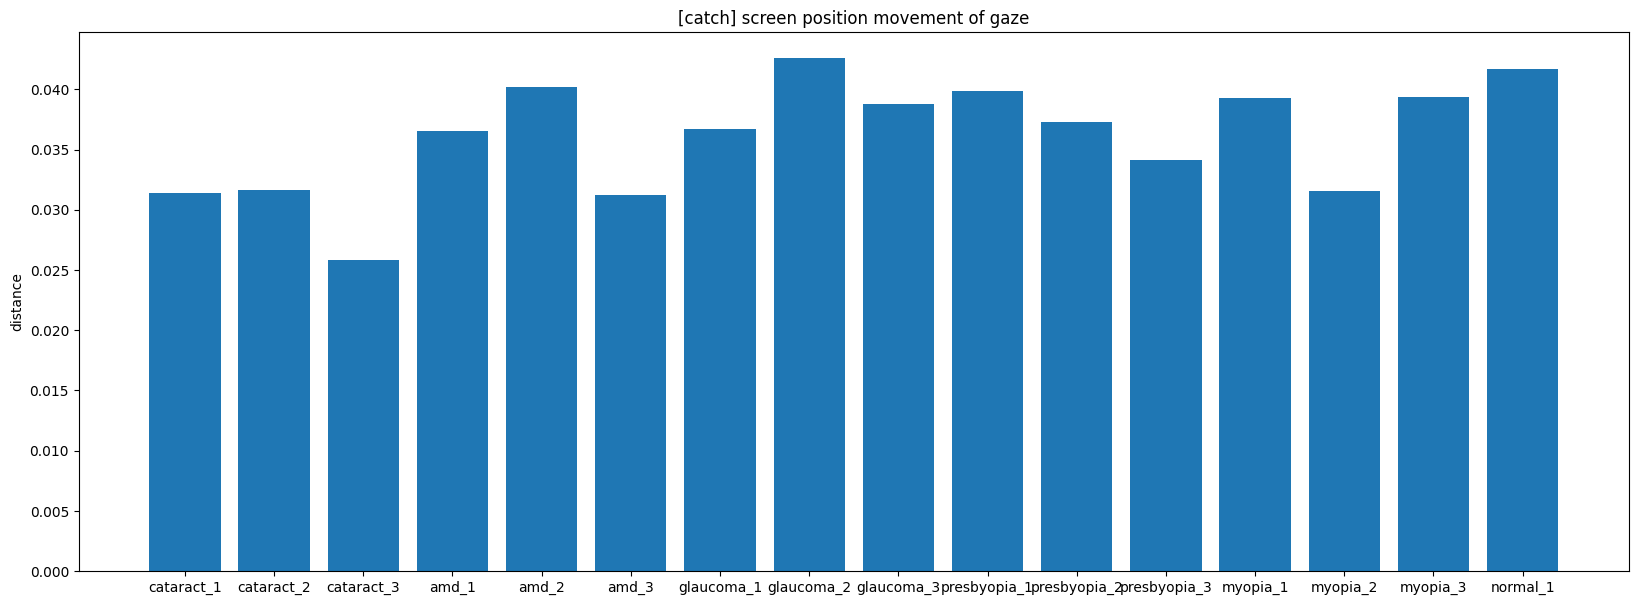

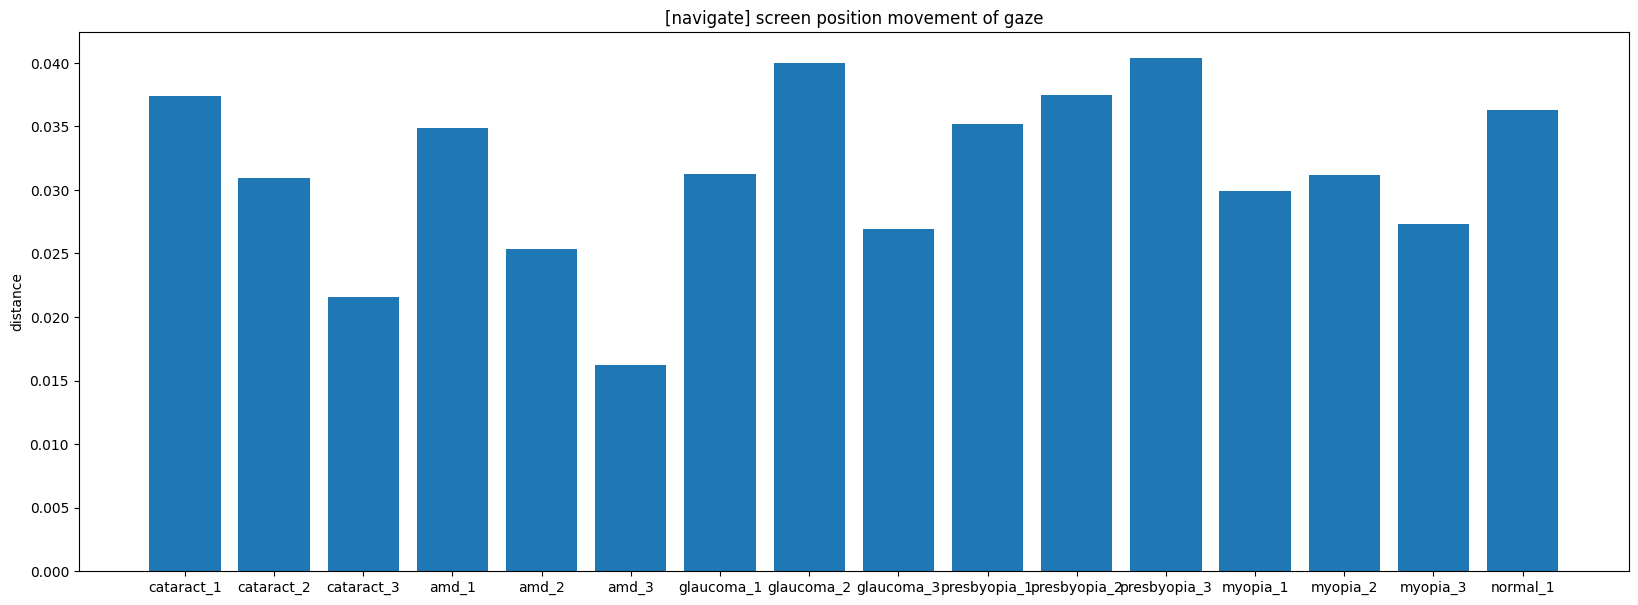

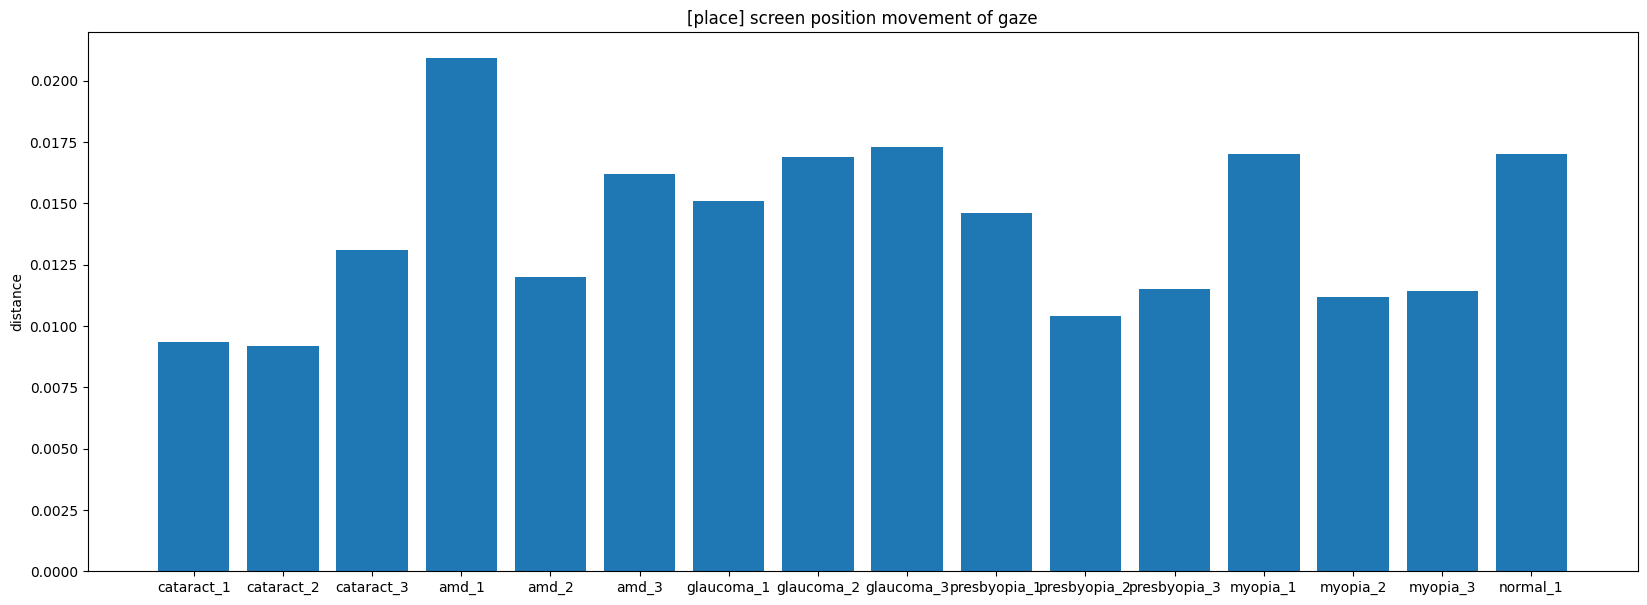

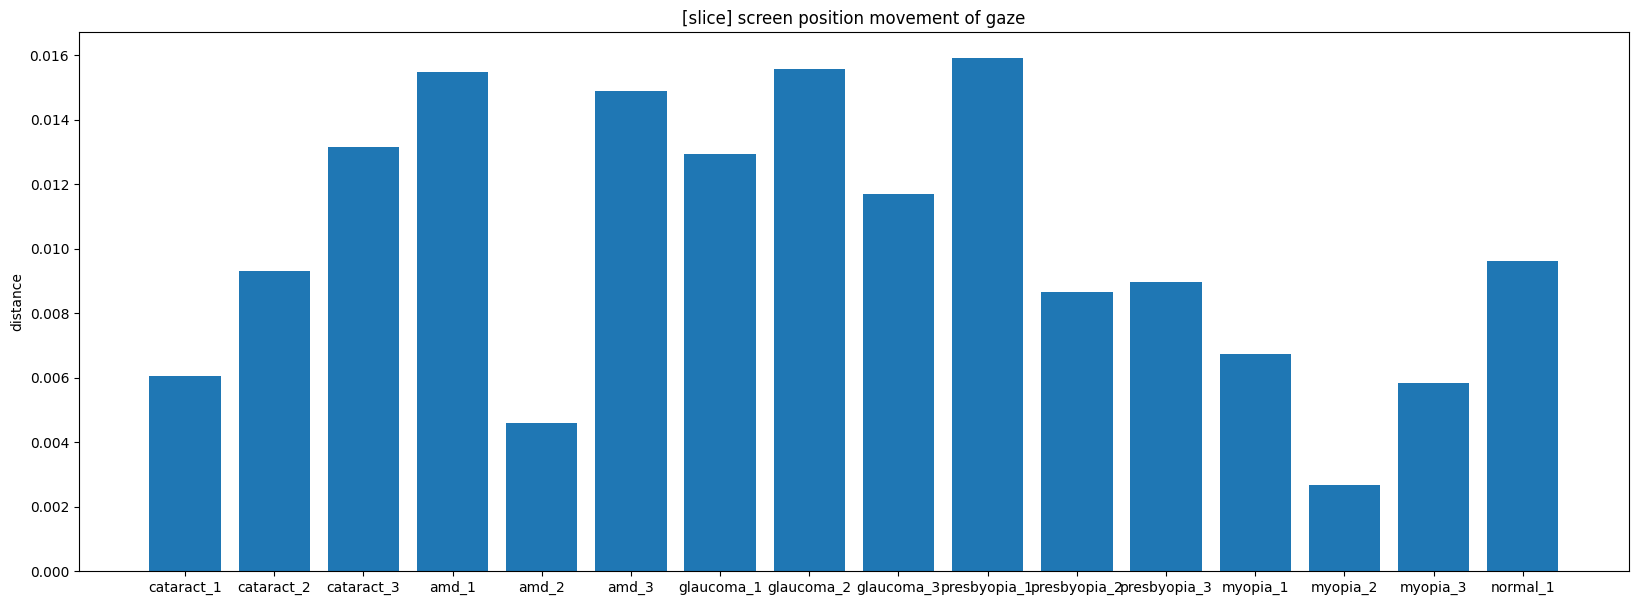

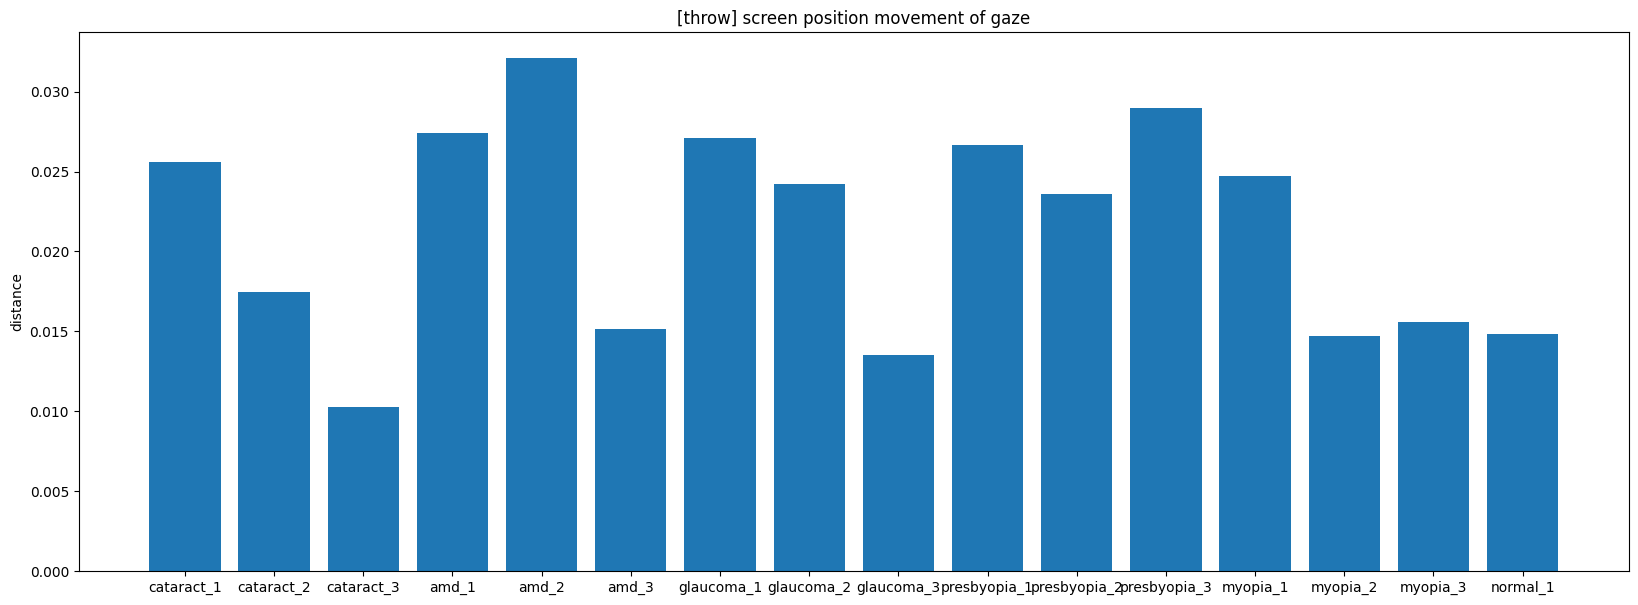

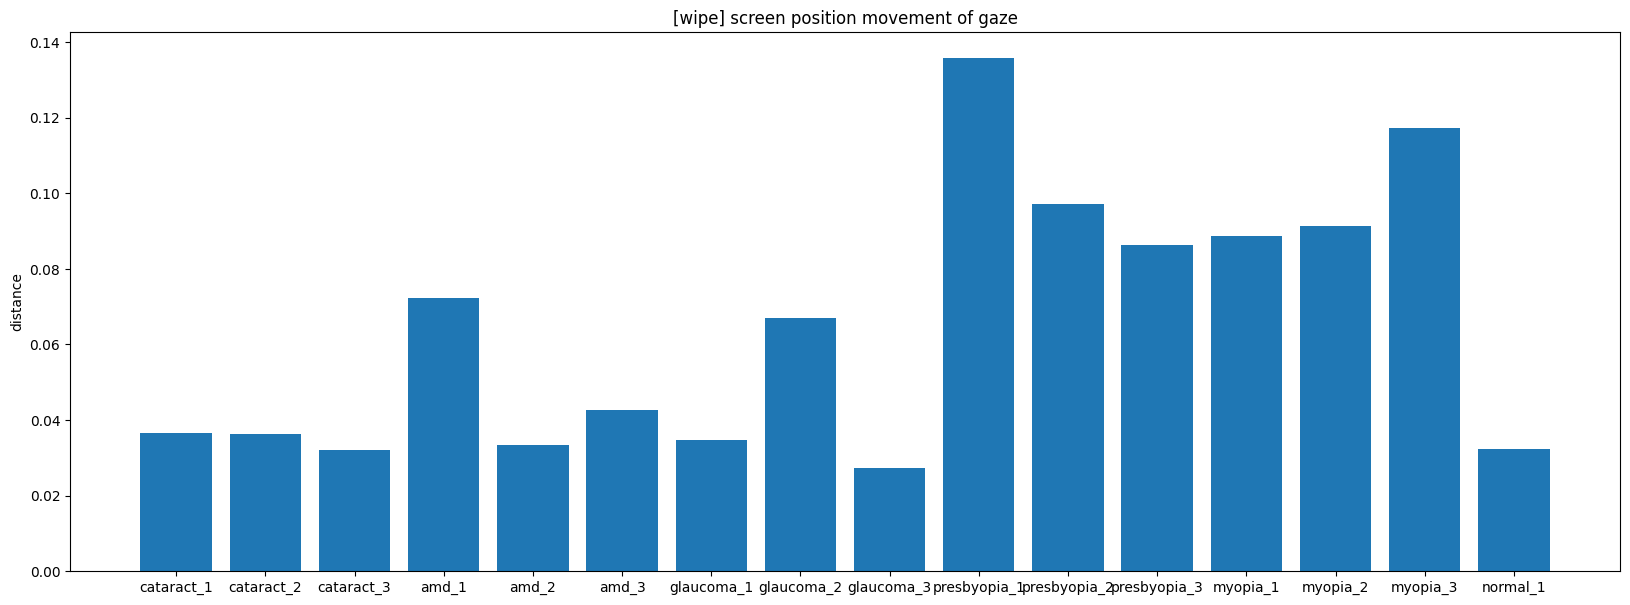

In [5]:
avg_eye_data = {task: {} for task in tasks}
for task in tasks:
    for vi in vis:
        avg_eye_data[task][vi] = np.mean(list(eye_data[f"{task}_{vi}"].values()))
    vi_data.bar_plot(data=list(avg_eye_data[task].values()), tick_label=vis, title=f"[{task}] screen position movement of gaze", ylabel="distance")

## Task completion time

In [6]:
completion_time = vi_data.get_attr(key="/metadata/task_completion_time")

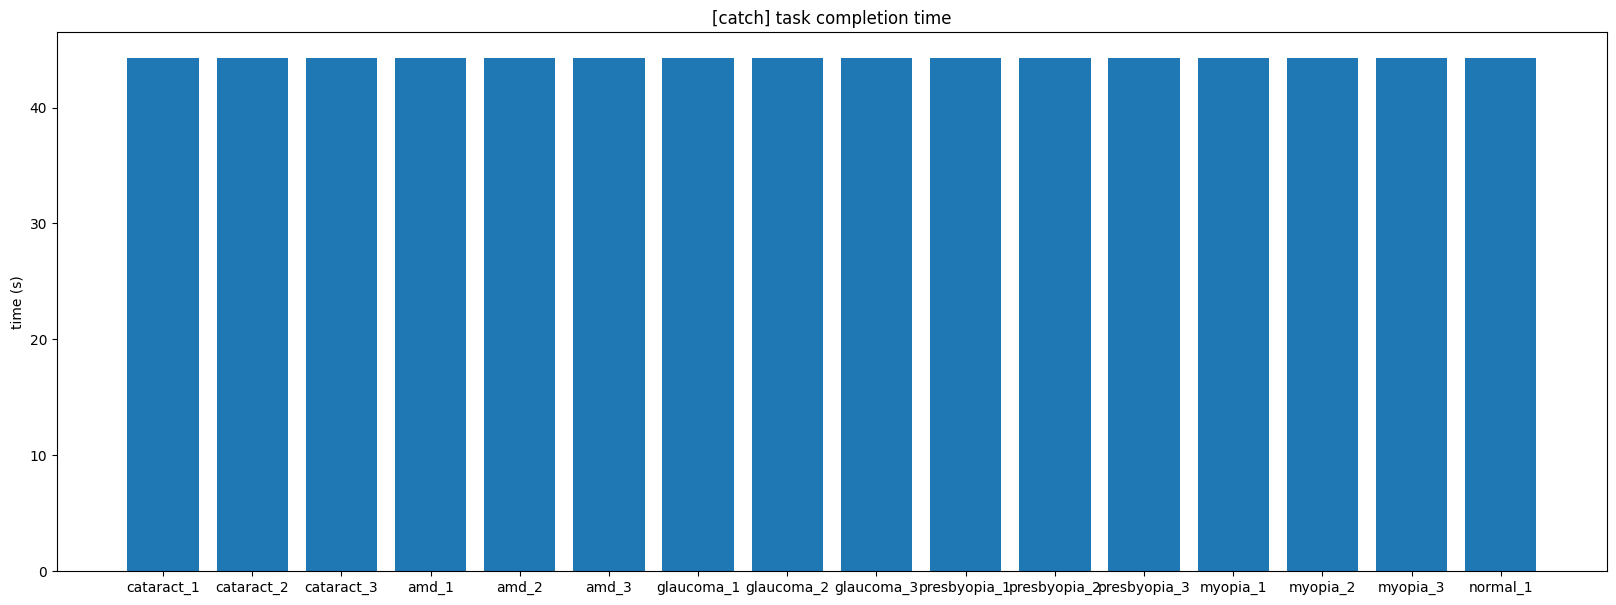

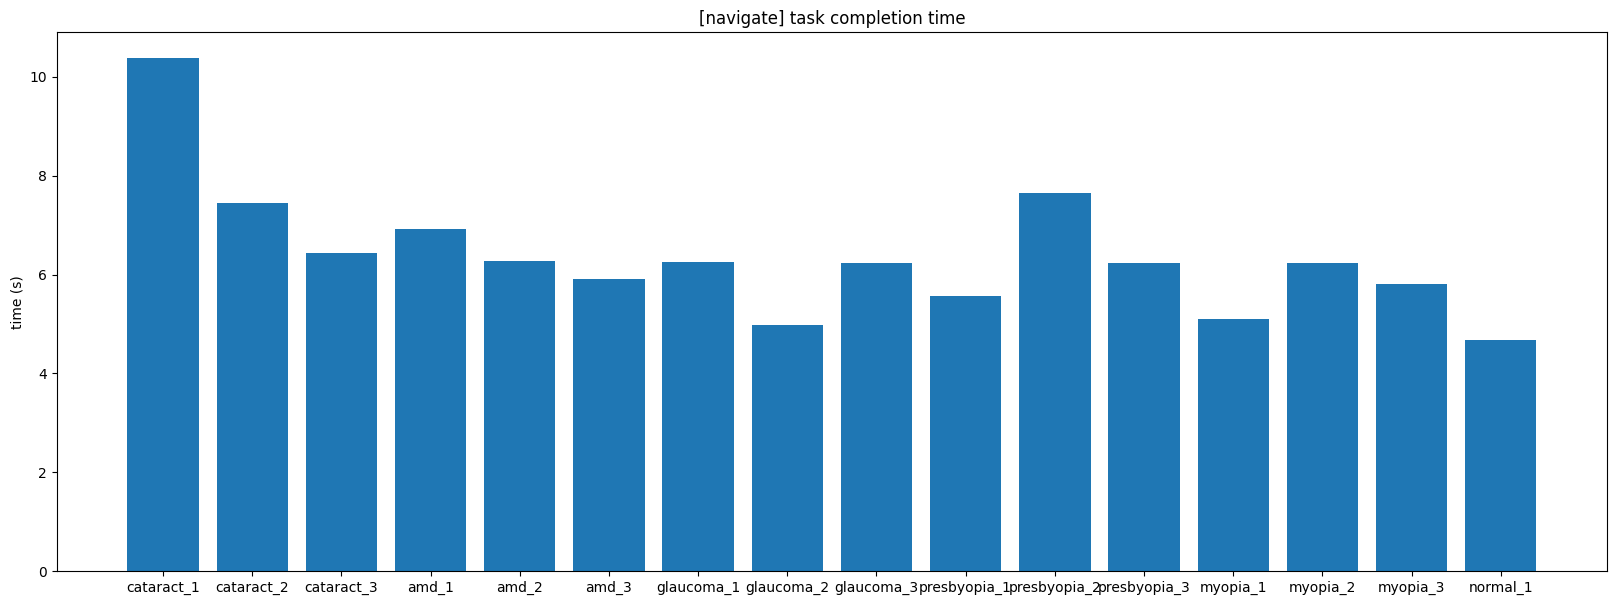

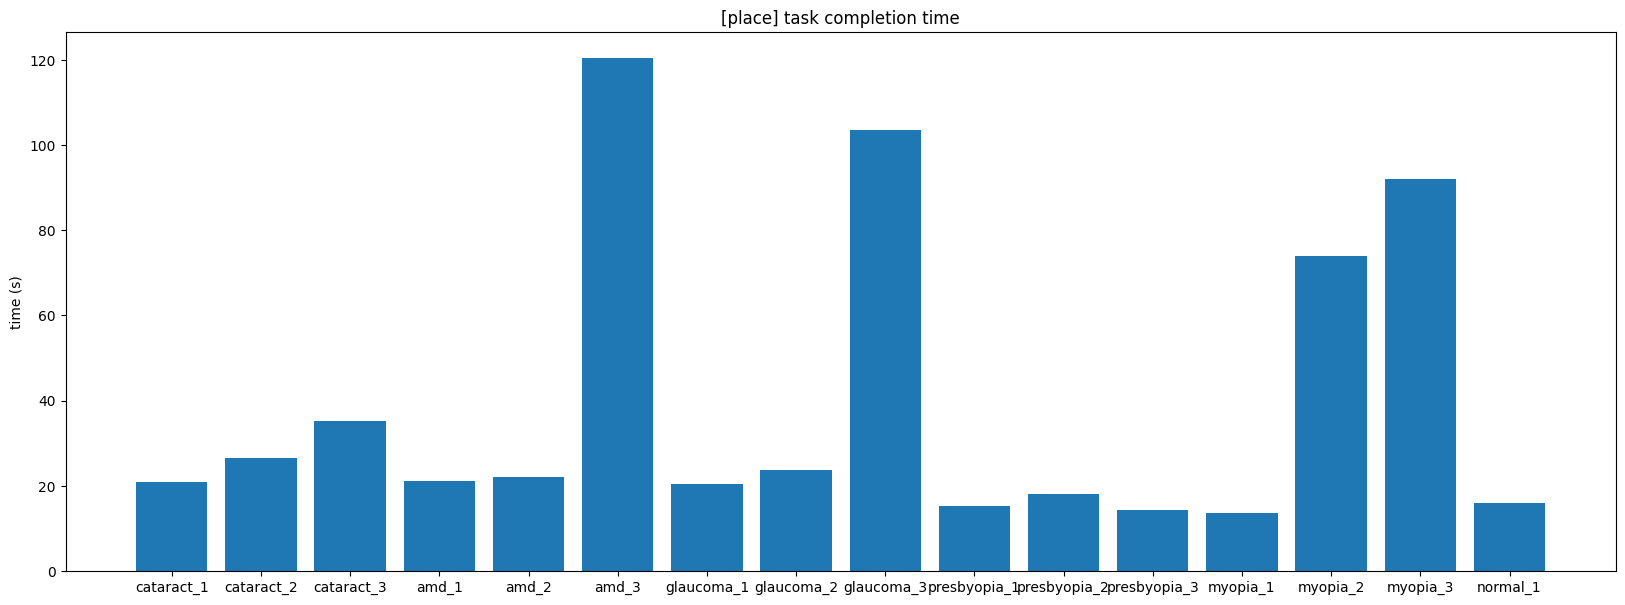

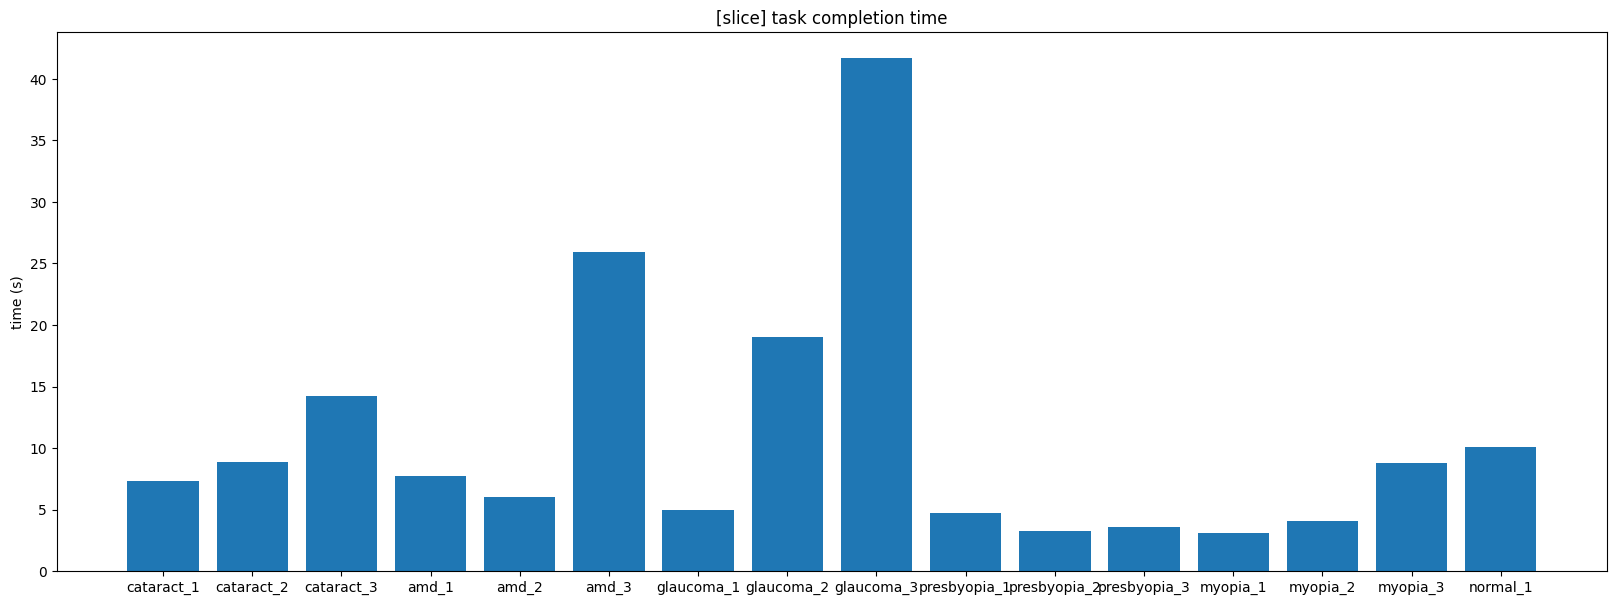

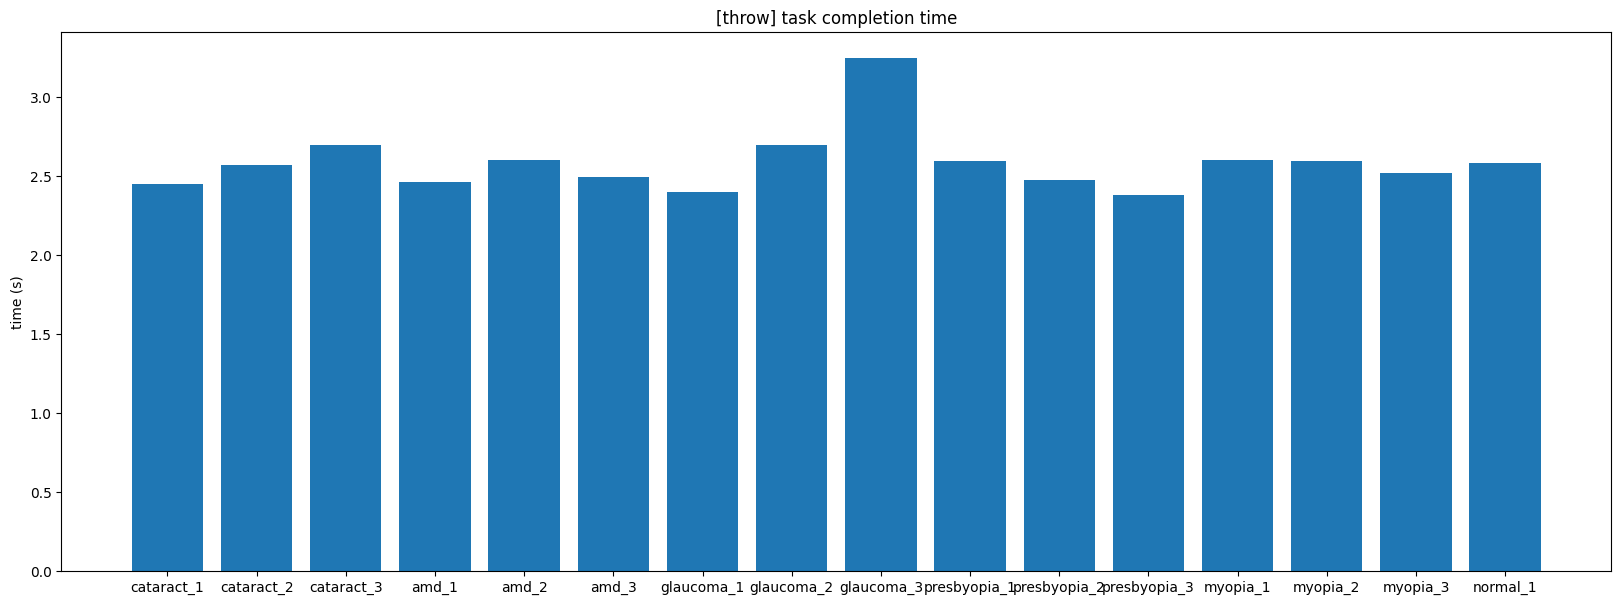

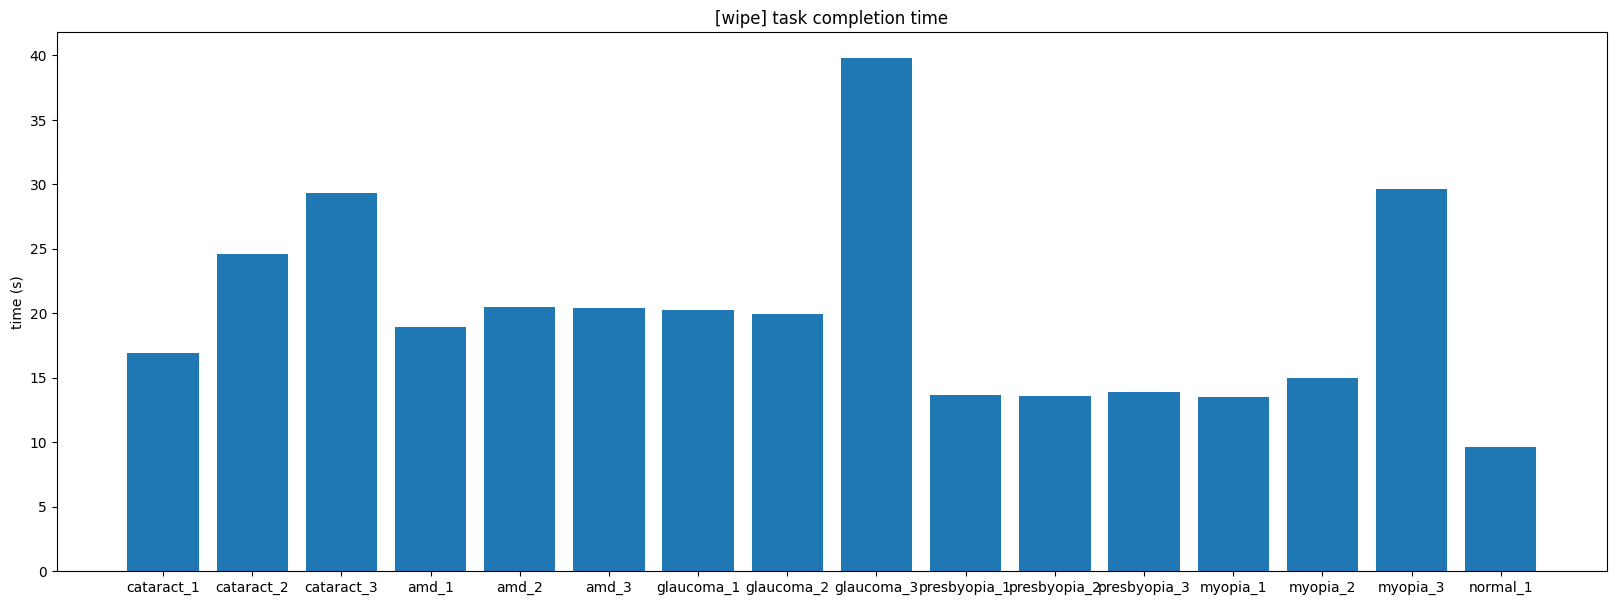

In [7]:
avg_completion_time = {task: {} for task in tasks}
for task in tasks:
    for vi in vis:
        avg_completion_time[task][vi] = np.mean(list(completion_time[f"{task}_{vi}"].values()))
    vi_data.bar_plot(data=list(avg_completion_time[task].values()), tick_label=vis, title=f"[{task}] task completion time", ylabel="time (s)")

## Head Movements

In [8]:
hmd_translation_data = vi_data.get_device_translation(device="hmd", method=np.sum)
hmd_rotation_data = vi_data.get_device_rotation(device="hmd", method=np.sum)

c:\users\capri28\documents\ig2\igibson\utils\vi_log_util.py:155: RuntimeWarning: invalid value encountered in arccos
  total_trajectory_rot[c_id][t_id].append(np.arccos((prev_quat @ x[4:8]) / (np.linalg.norm(prev_quat) * np.linalg.norm(x[4:8]))))


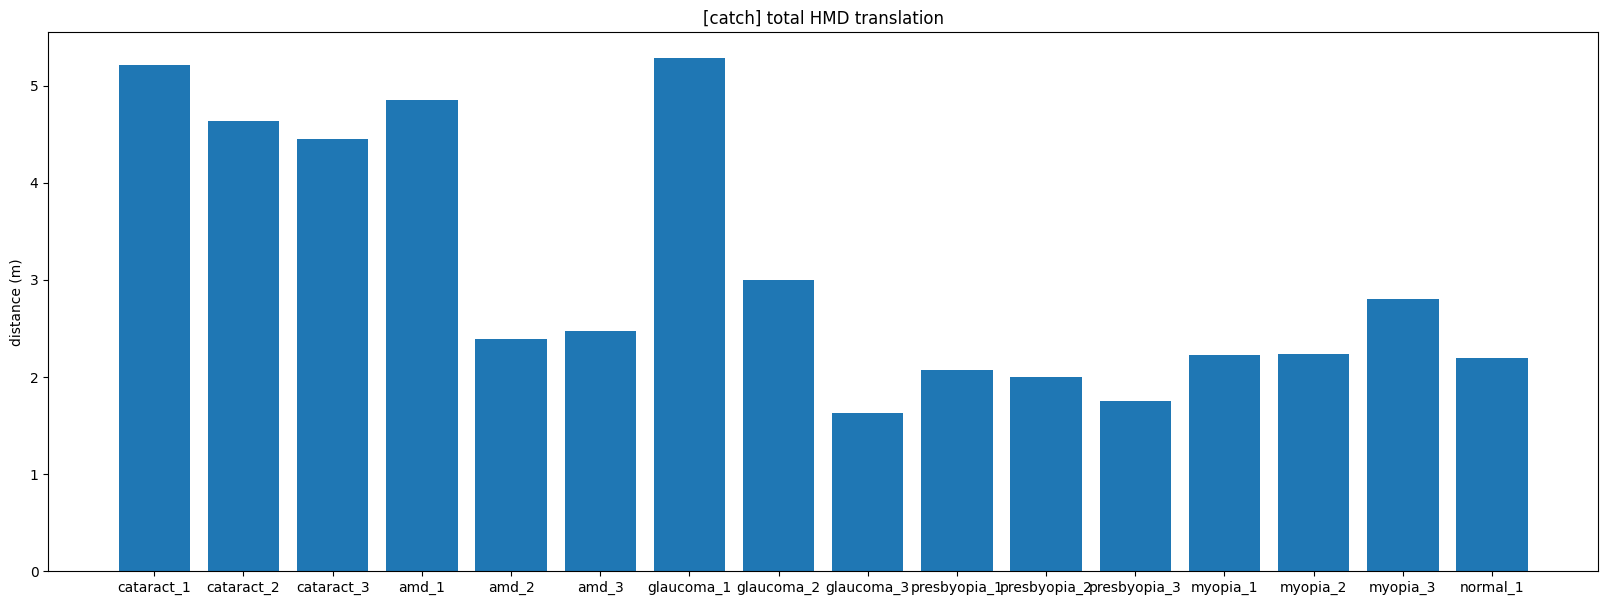

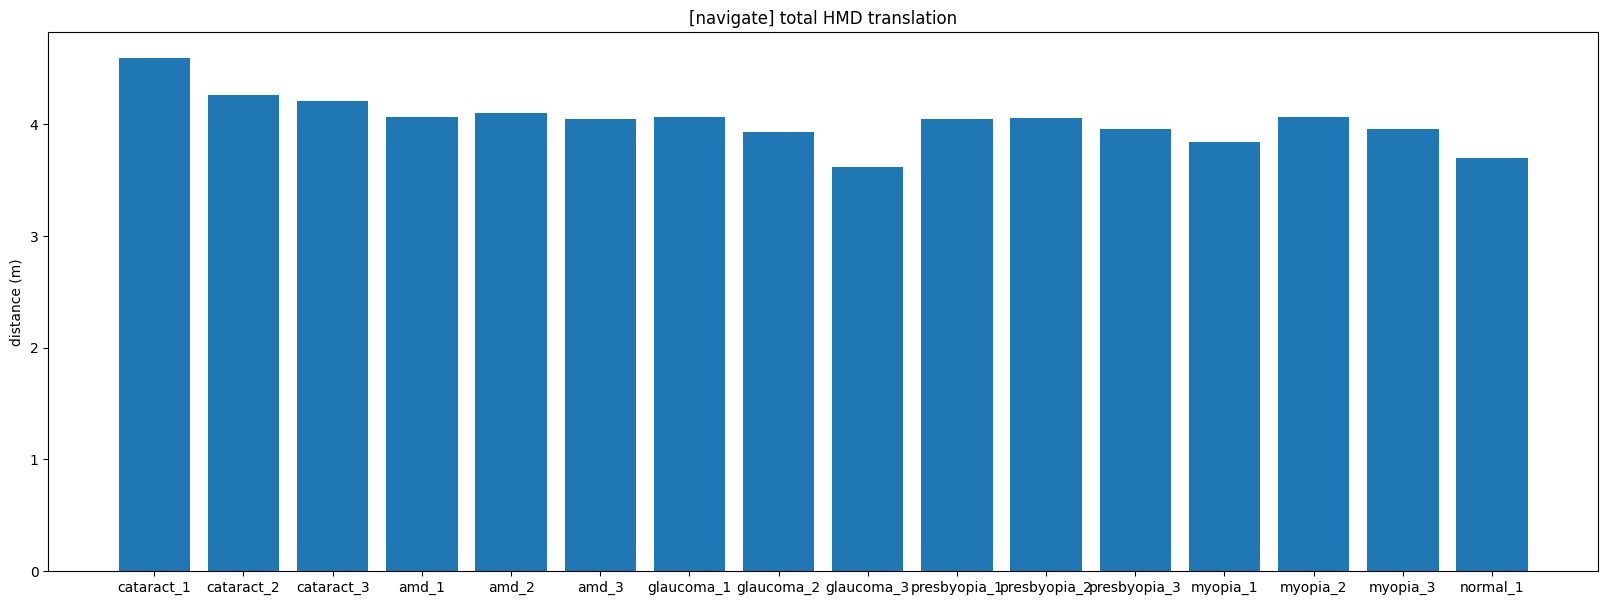

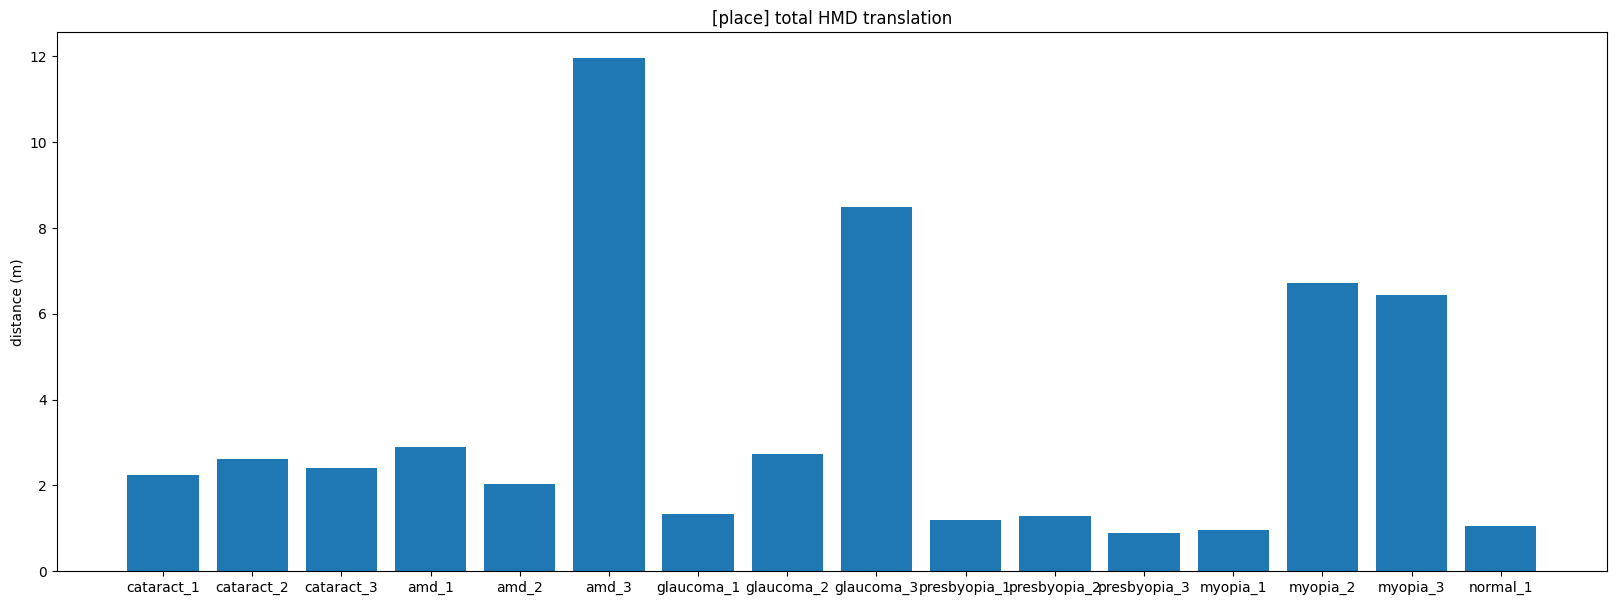

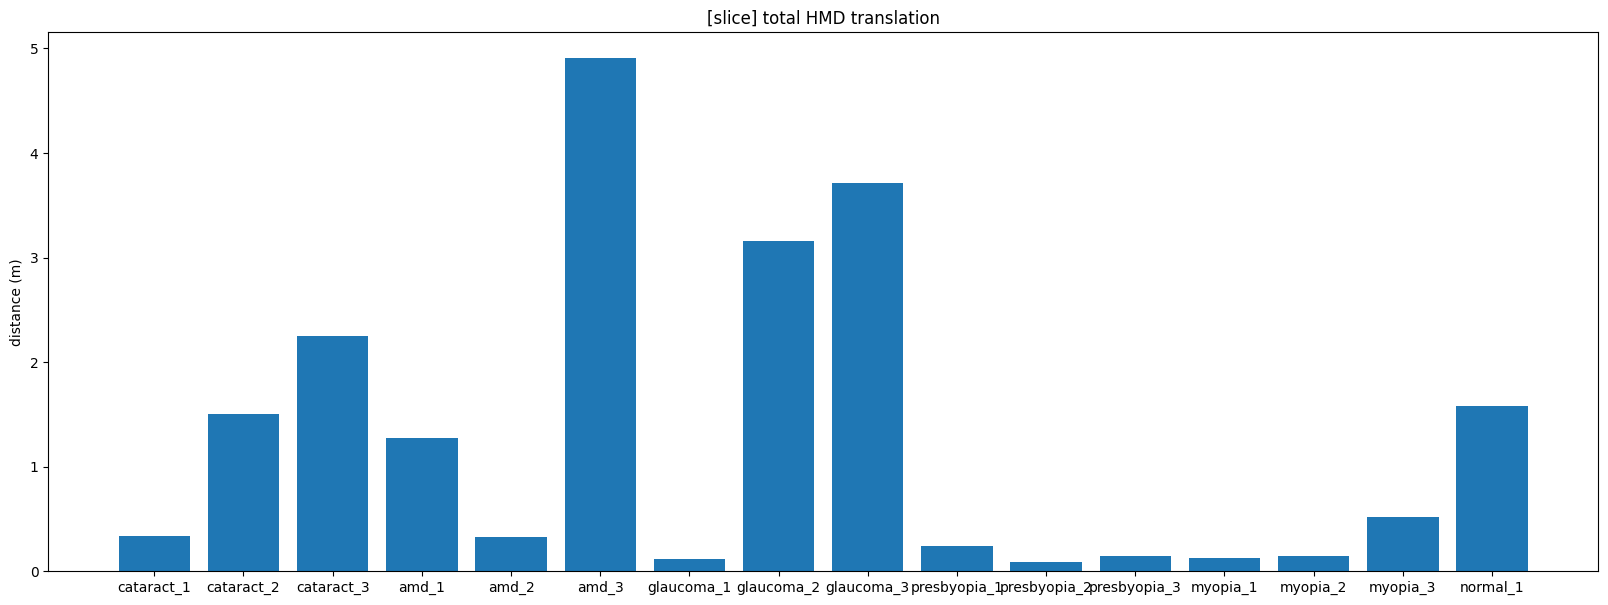

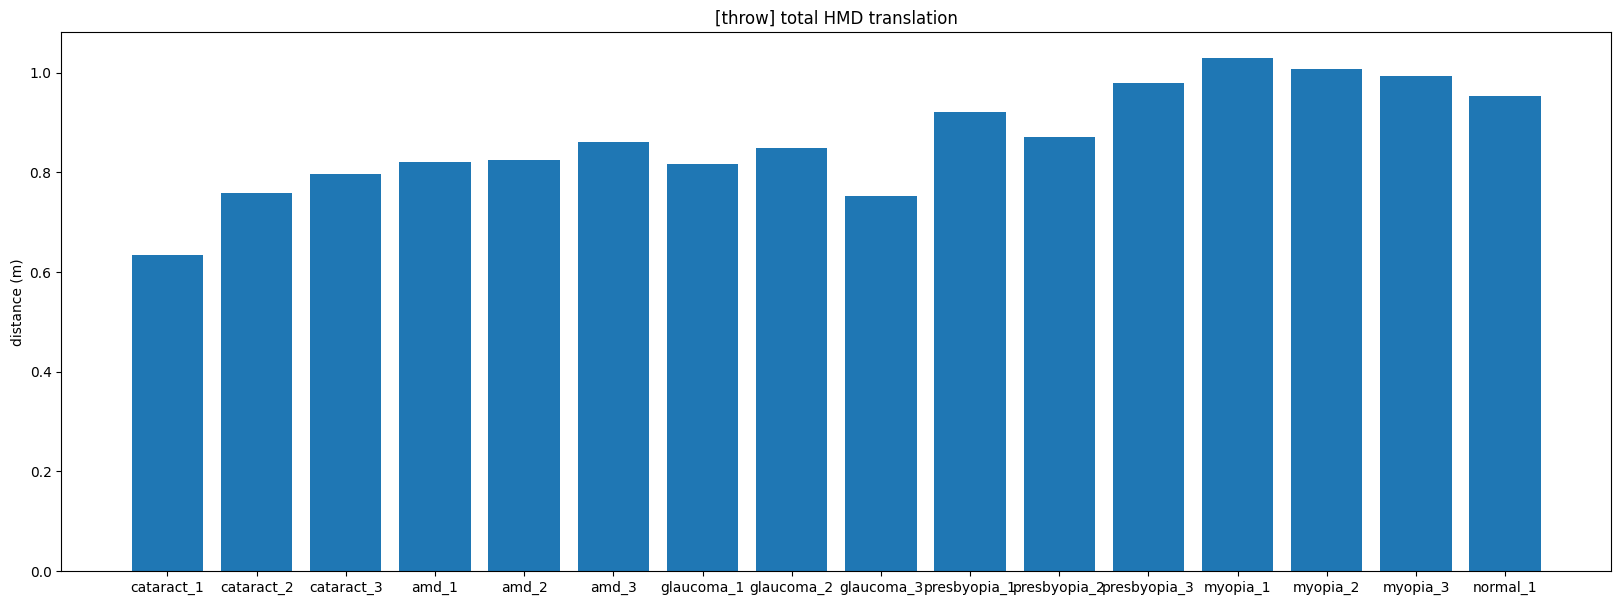

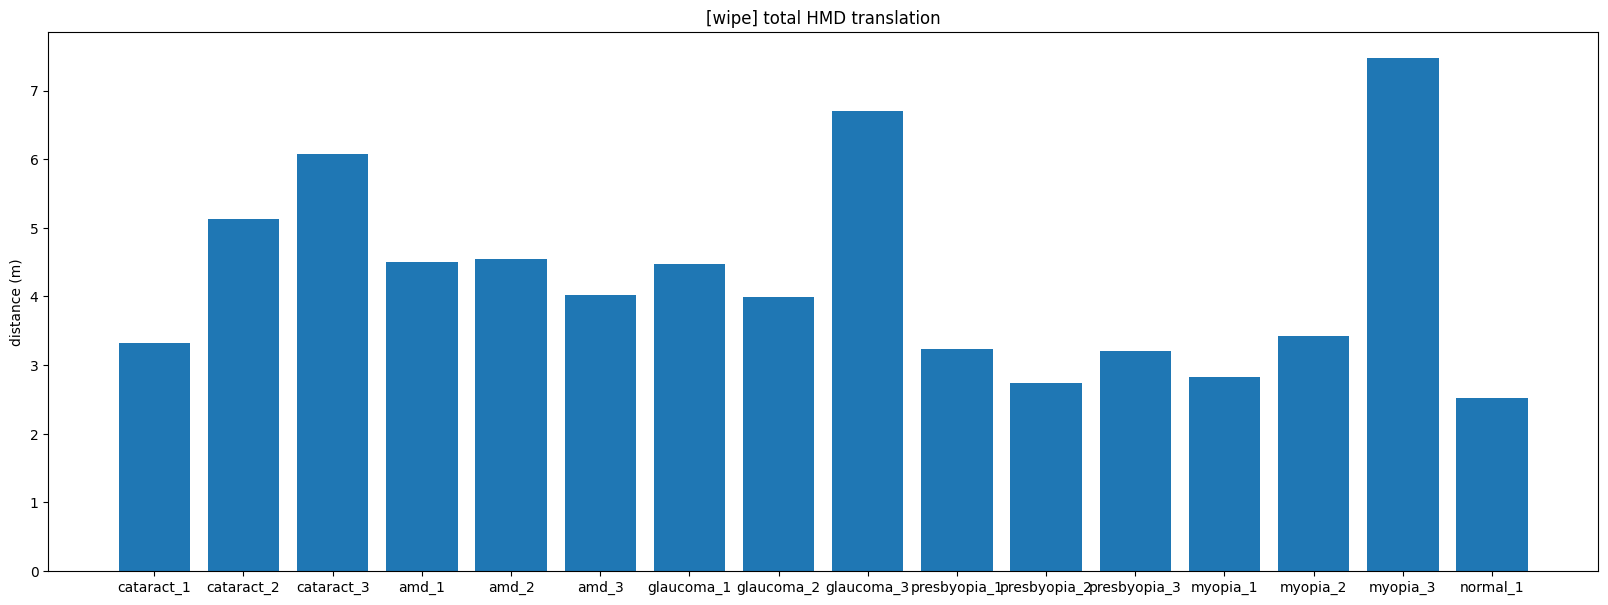

In [9]:
avg_hmd_translation_data = {task: {} for task in tasks}
for task in tasks:
    for vi in vis:
        avg_hmd_translation_data[task][vi] = np.mean(list(hmd_translation_data[f"{task}_{vi}"].values()))
    vi_data.bar_plot(data=list(avg_hmd_translation_data[task].values()), tick_label=vis, title=f"[{task}] total HMD translation", ylabel="distance (m)")

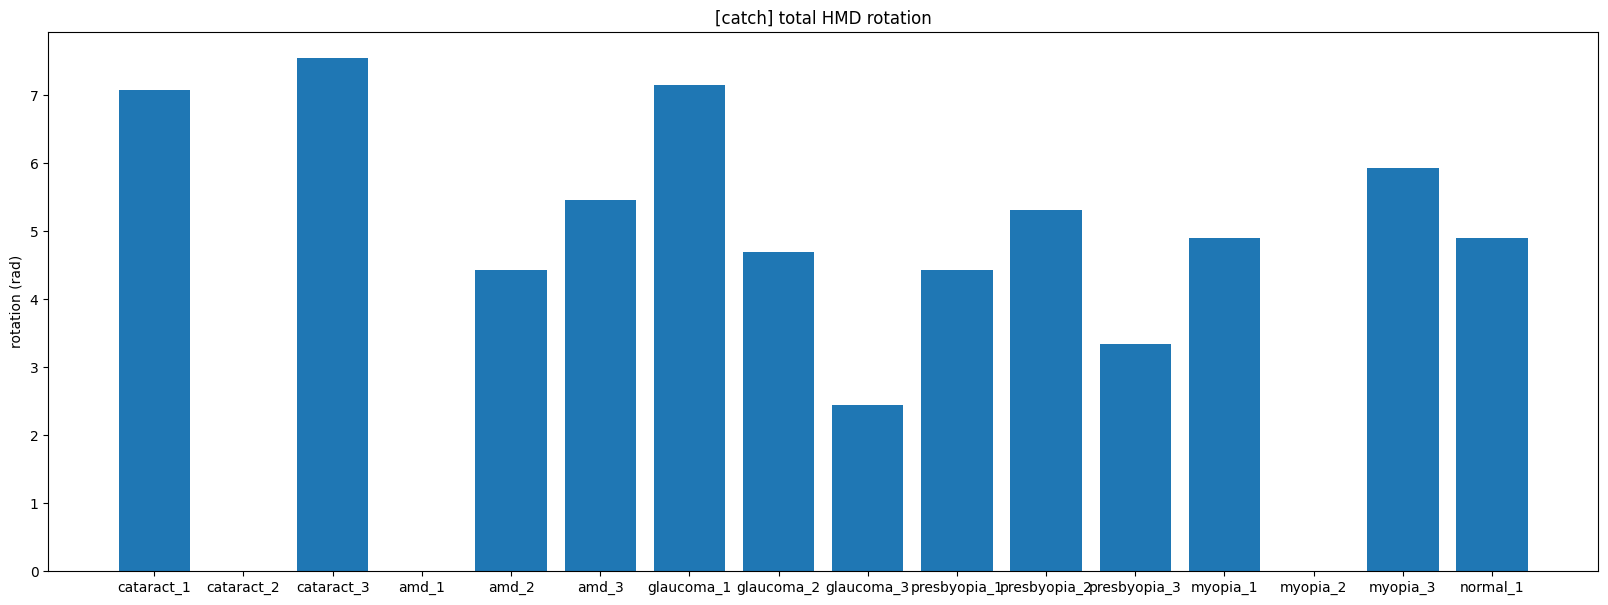

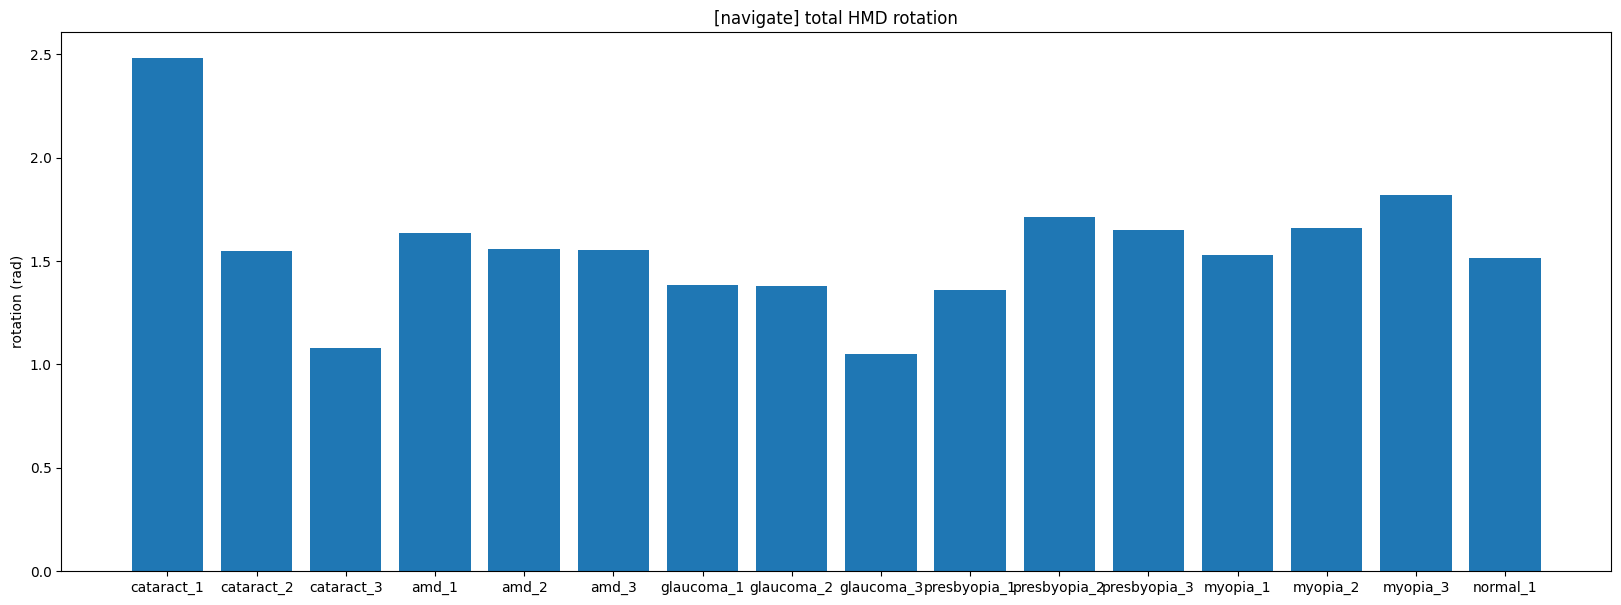

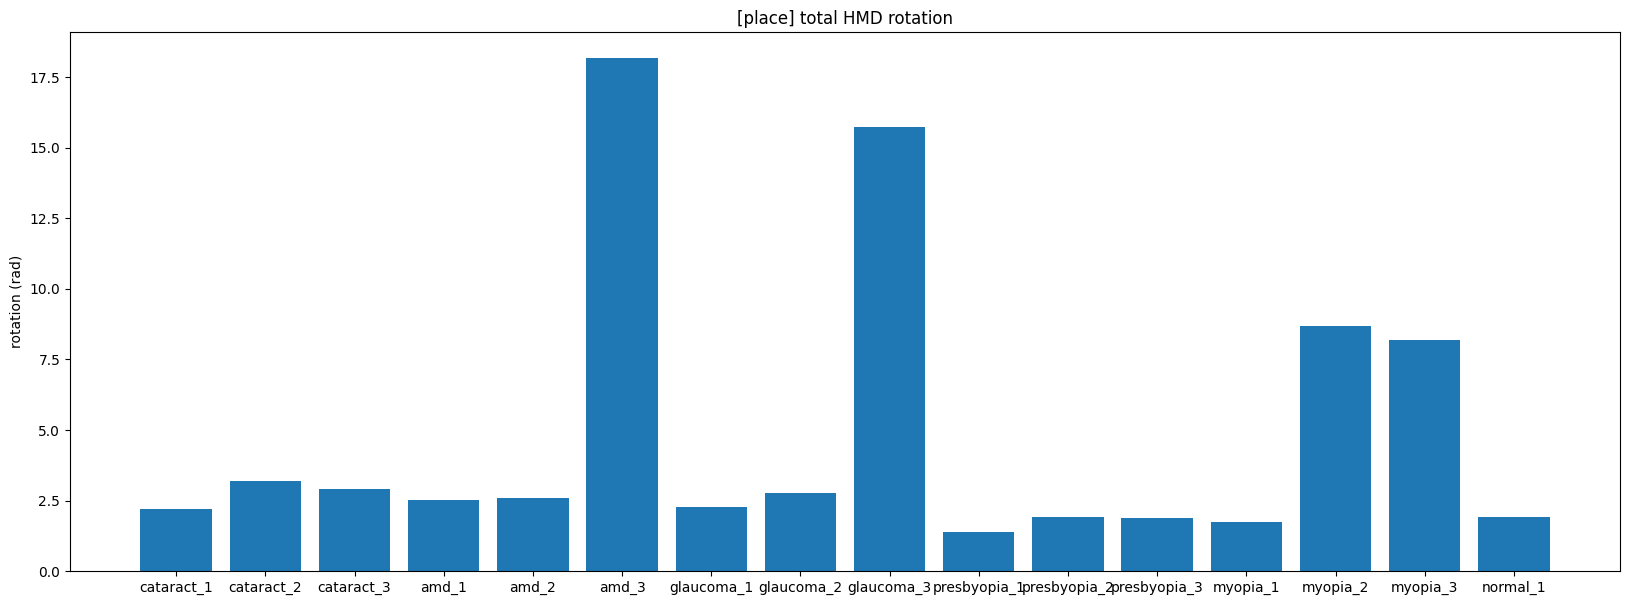

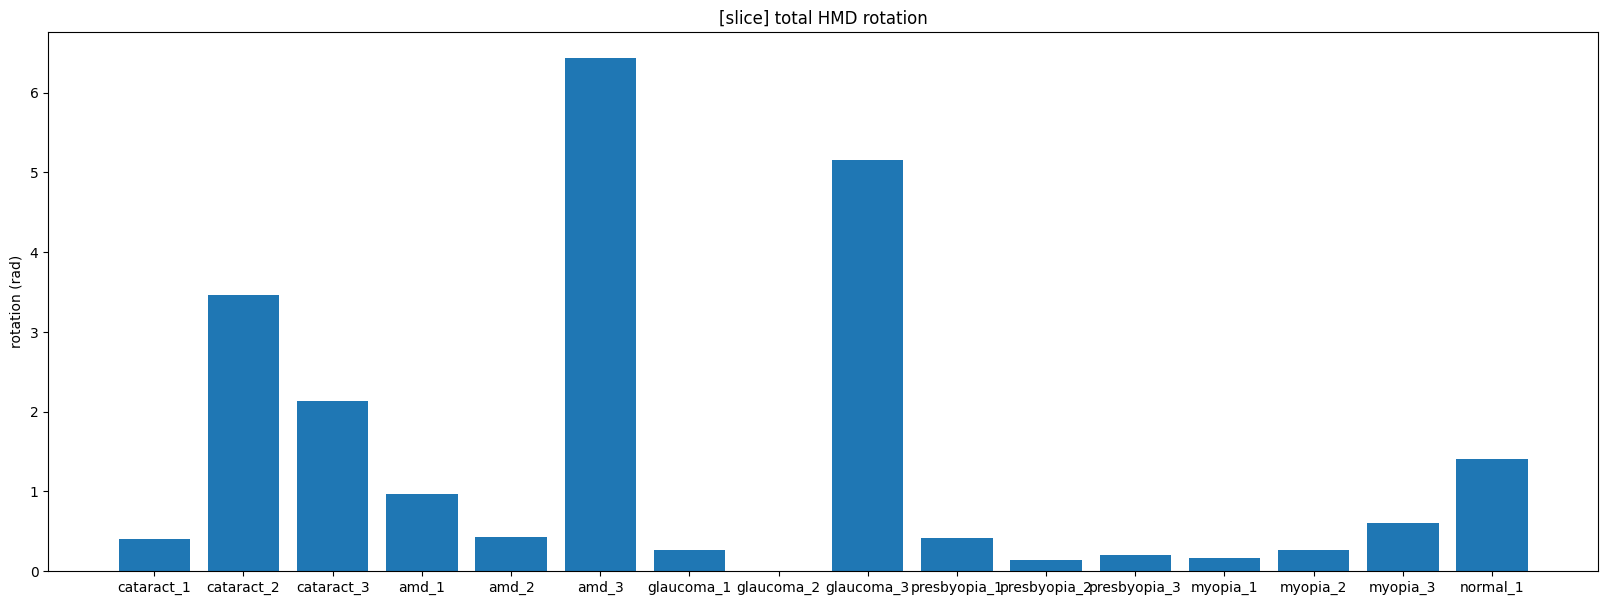

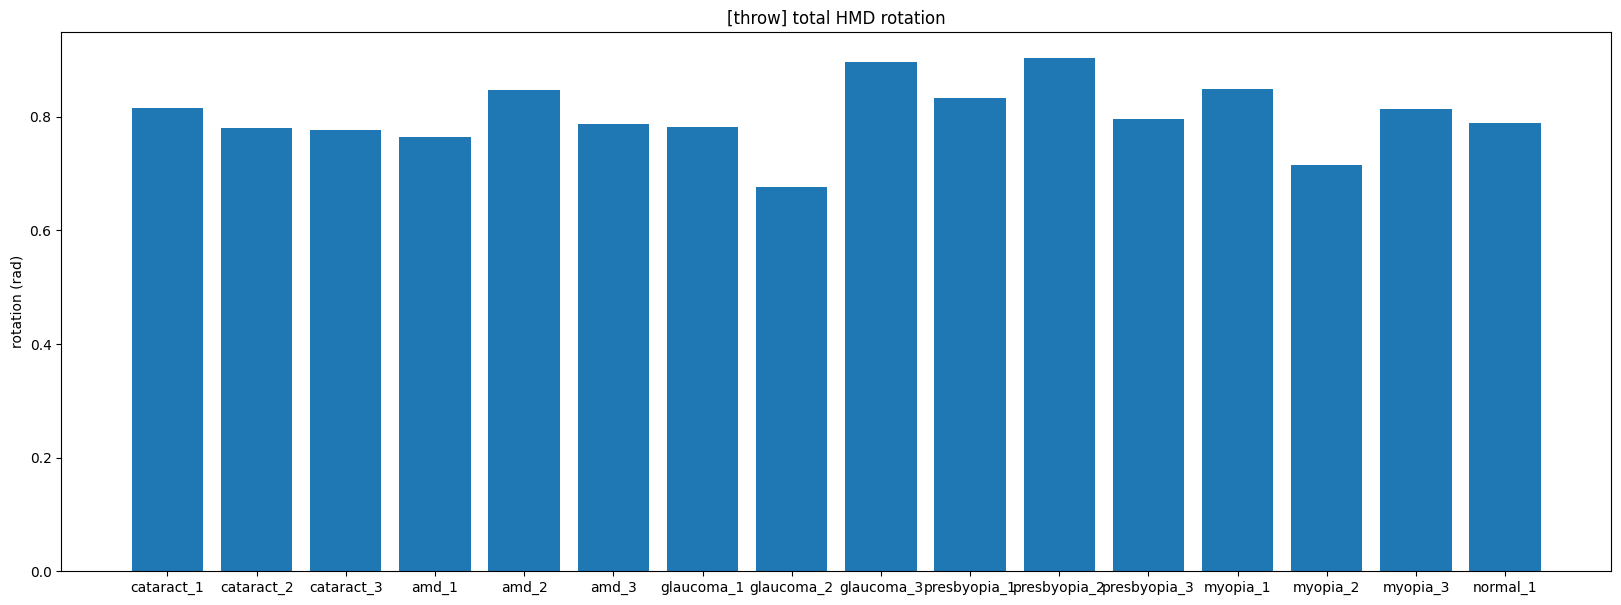

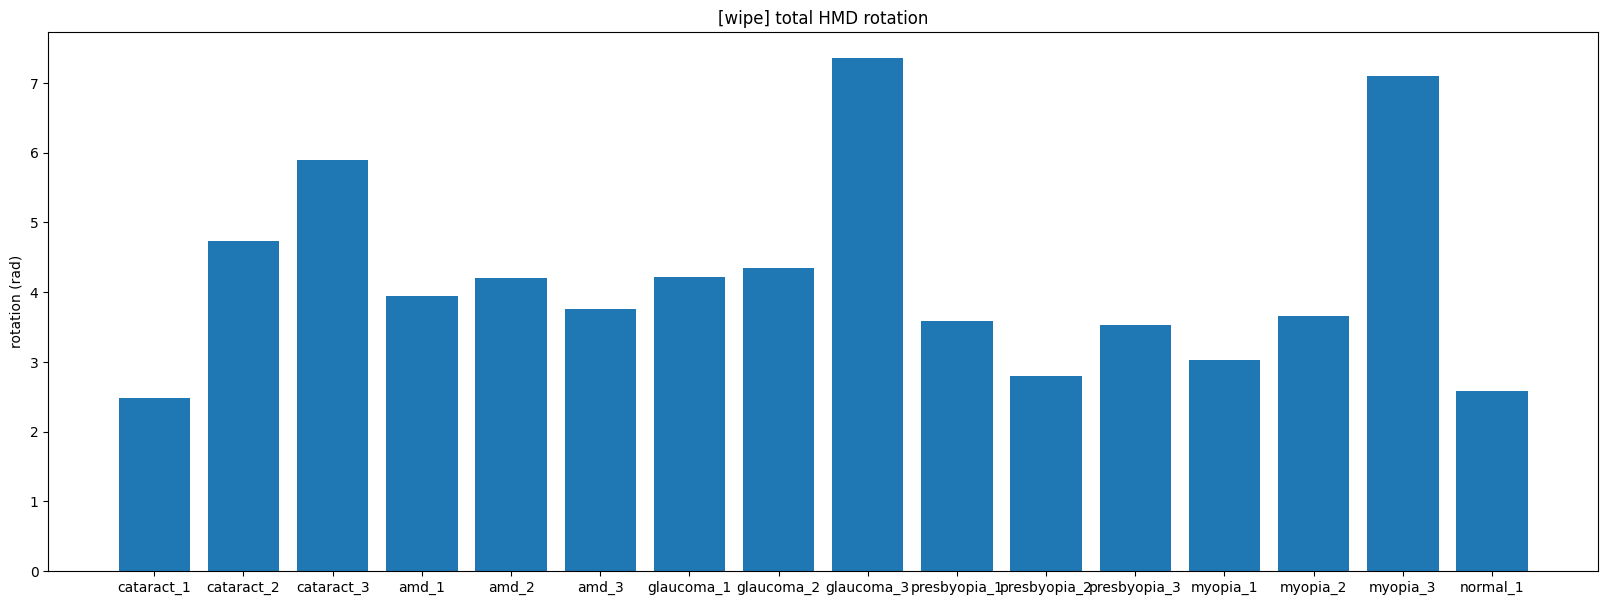

In [10]:
avg_hmd_rotation_data = {task: {} for task in tasks}
for task in tasks:
    for vi in vis:
        avg_hmd_rotation_data[task][vi] = np.mean(list(hmd_rotation_data[f"{task}_{vi}"].values()))
    vi_data.bar_plot(data=list(avg_hmd_rotation_data[task].values()), tick_label=vis, title=f"[{task}] total HMD rotation", ylabel="rotation (rad)")

## Others

### Success Rate (SR) for catch and throw

In [11]:
sr_task = ["catch", "throw"]
sr = vi_data.get_attr(key="/metadata/success", cond_id=[f"{task}_{vi}" for task, vi in product(sr_task, vis)])

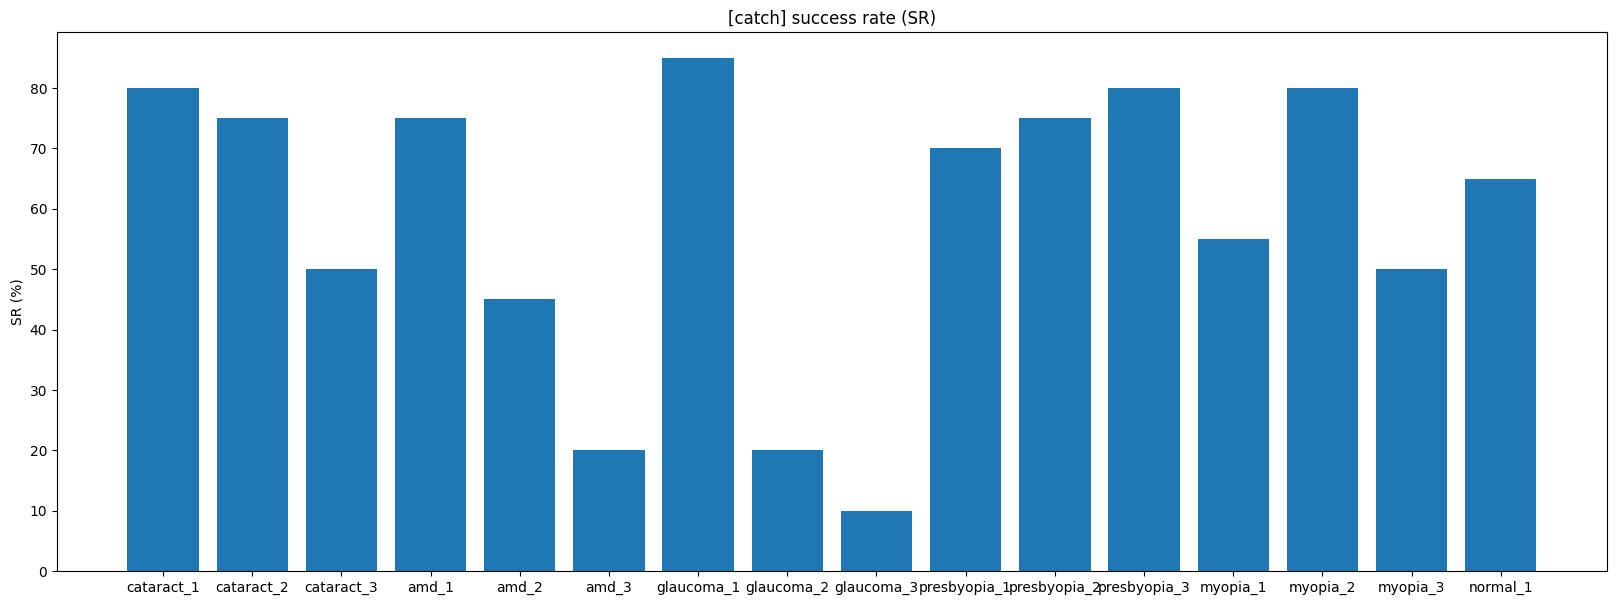

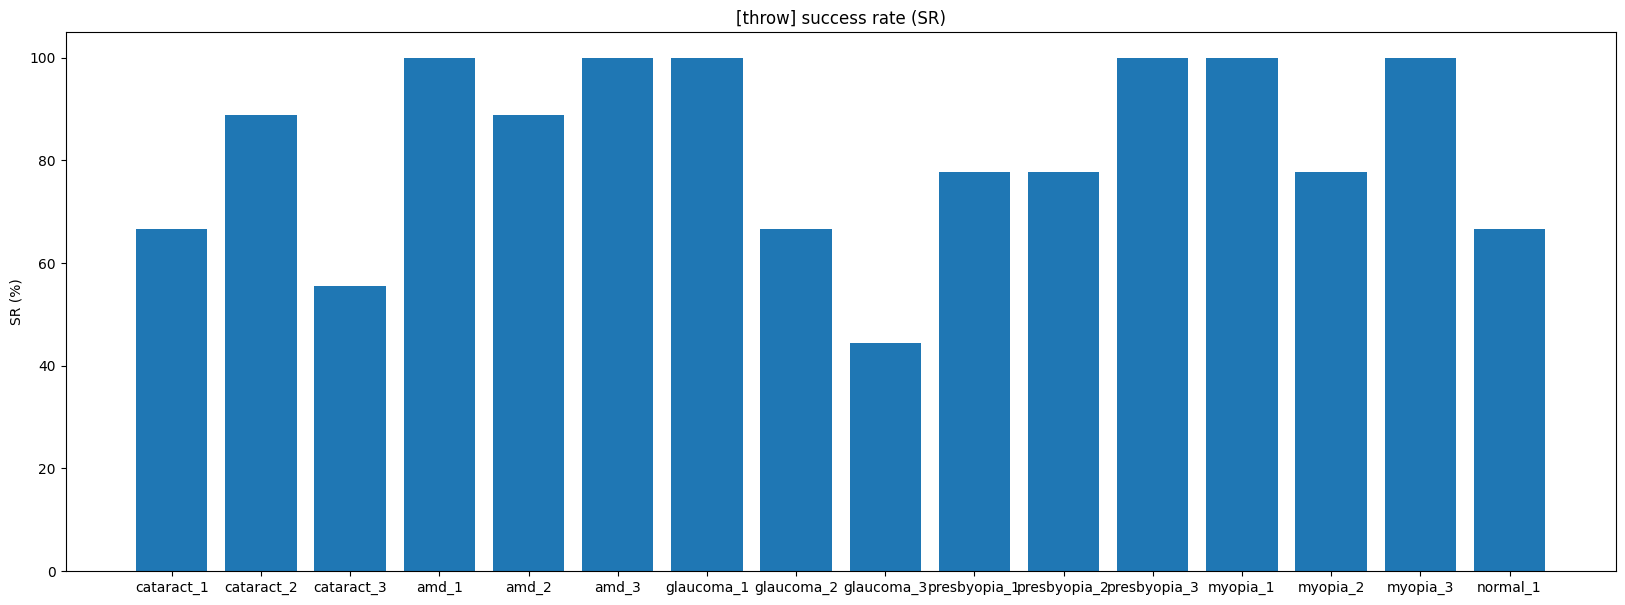

In [12]:
avg_sr = {task: {} for task in tasks}
for task in sr_task:
    for vi in vis:
        avg_sr[task][vi] = np.mean(list(sr[f"{task}_{vi}"].values()))    
    vi_data.bar_plot(data=np.array(list(avg_sr[task].values()))*100, tick_label=vis, title=f"[{task}] success rate (SR)", ylabel="SR (%)")

### Fixation variation for catch

In [13]:
# TODO
hdf = h5py.File(rf"{data_path}/0/catch/normal_1/20230106_134430/0.hdf5", "r")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'c:/Users/capri28/Documents/ig2/igibson/data/vi_data/demo/0/catch/normal_1/20230106_134430/0.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
is_valid = np.array(hdf["vr"]["vr_eye_tracking_data"][:, 0])
ori = np.array(hdf["vr"]["vr_eye_tracking_data"][:, 1:4])
dir = np.array(hdf["vr"]["vr_eye_tracking_data"][:, 4:7])
left_ori = np.array(hdf["vr"]["vr_eye_tracking_data"][:, -12:-9])
left_dir = np.array(hdf["vr"]["vr_eye_tracking_data"][:, -9:-6])
right_ori = np.array(hdf["vr"]["vr_eye_tracking_data"][:, -6:-3])
right_dir = np.array(hdf["vr"]["vr_eye_tracking_data"][:, -3:])

In [ ]:
print(is_valid[100])
print(left_dir[100], right_dir[100], dir[100])
print(left_ori[100], right_ori[100], ori[100])

1.0
[ 0.99743497 -0.01147355 -0.07065426] [ 0.99232405  0.06298894 -0.10642175] [ 0.99521768  0.03284879 -0.09199339]
[-1.61059201 -0.26422817  1.14419258] [-1.602404   -0.32853943  1.14198697] [-1.6057229  -0.30247238  1.14288092]


In [ ]:
hdf.close()

### Distance between ball and basket for throw

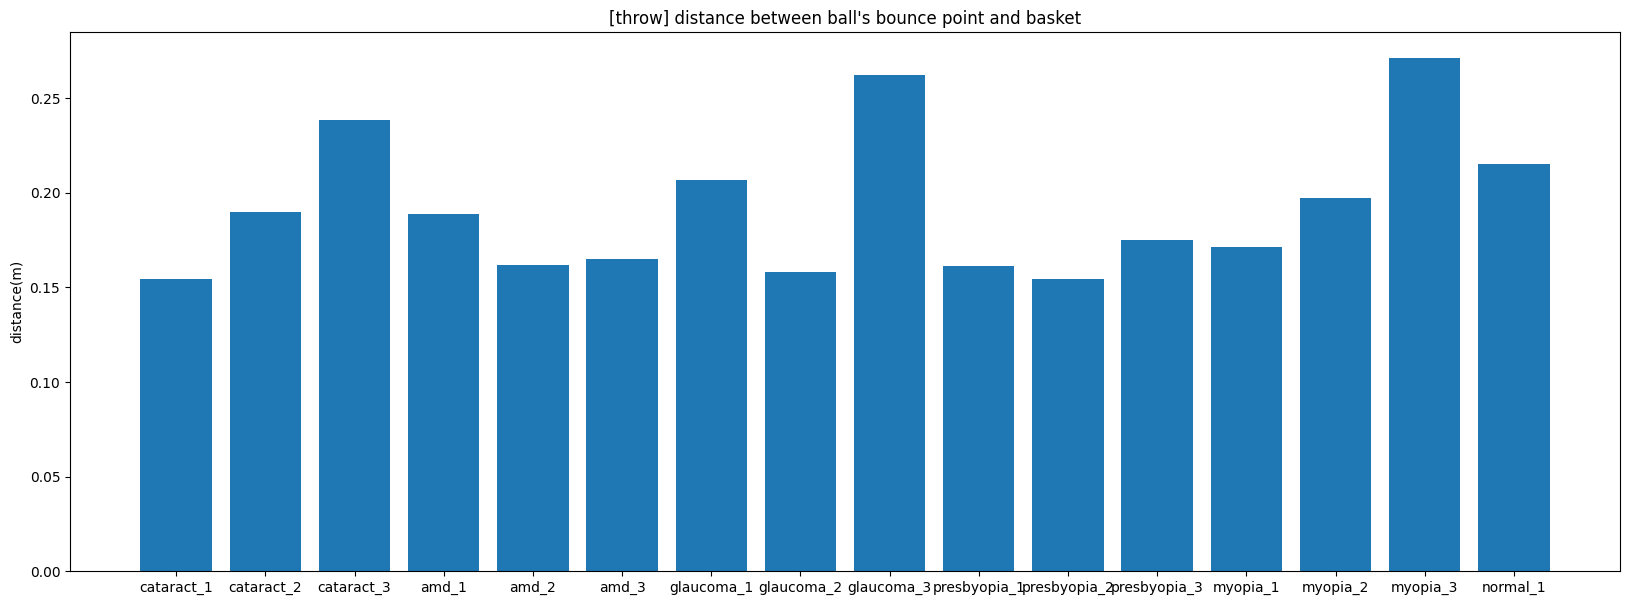

In [ ]:
# from analysis, the object id of ball and basket are 10, 11 respectively
# We consider the ball hits the ground if its z value is < 0.05
avg_distance = {vi : [] for vi in vis}
for vi in vis:
    for trial_id in vi_data.hfs[f"throw_{vi}"].keys():
        sphere_pos = vi_data.hfs[f"throw_{vi}"][trial_id]["physics_data/10/position"]
        basket_pos = vi_data.hfs[f"throw_{vi}"][trial_id]["physics_data/11/position"]
        bounce_time = np.argmax(sphere_pos[:, 2] < 0.05)
        avg_distance[vi].append(np.linalg.norm(sphere_pos[bounce_time] - basket_pos[bounce_time]))
    avg_distance[vi] = np.mean(avg_distance[vi])
vi_data.bar_plot(data=avg_distance.values(), tick_label=vis, title=f"[throw] distance between ball's bounce point and basket", ylabel="distance(m)")

### Total movement of all objects of place

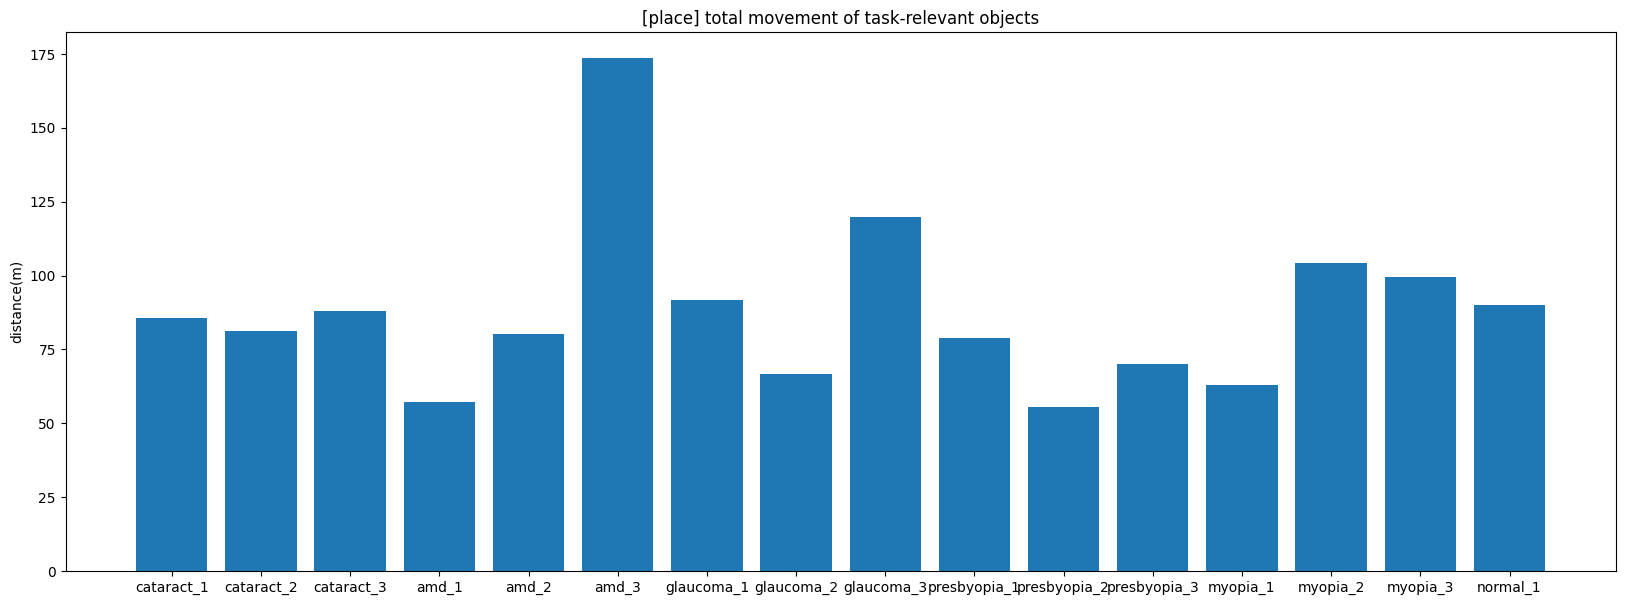

In [ ]:
# from analysis, the object id of baskets and cubes are 12-20
total_obj_movements = vi_data.get_object_translation(object_id=range(13, 21), cond_id=[f"place_{vi}" for vi in vis], method=np.sum)
avg_obj_movement = {task: {} for task in tasks}
for vi in vis:
    avg_obj_movement[task][vi] = np.mean(list(total_obj_movements[f"place_{vi}"].values()))    
vi_data.bar_plot(data=np.array(list(avg_obj_movement[task].values()))*100, tick_label=vis, title=f"[place] total movement of task-relevant objects", ylabel="distance(m)")

### collisions and trajectory length for navigate

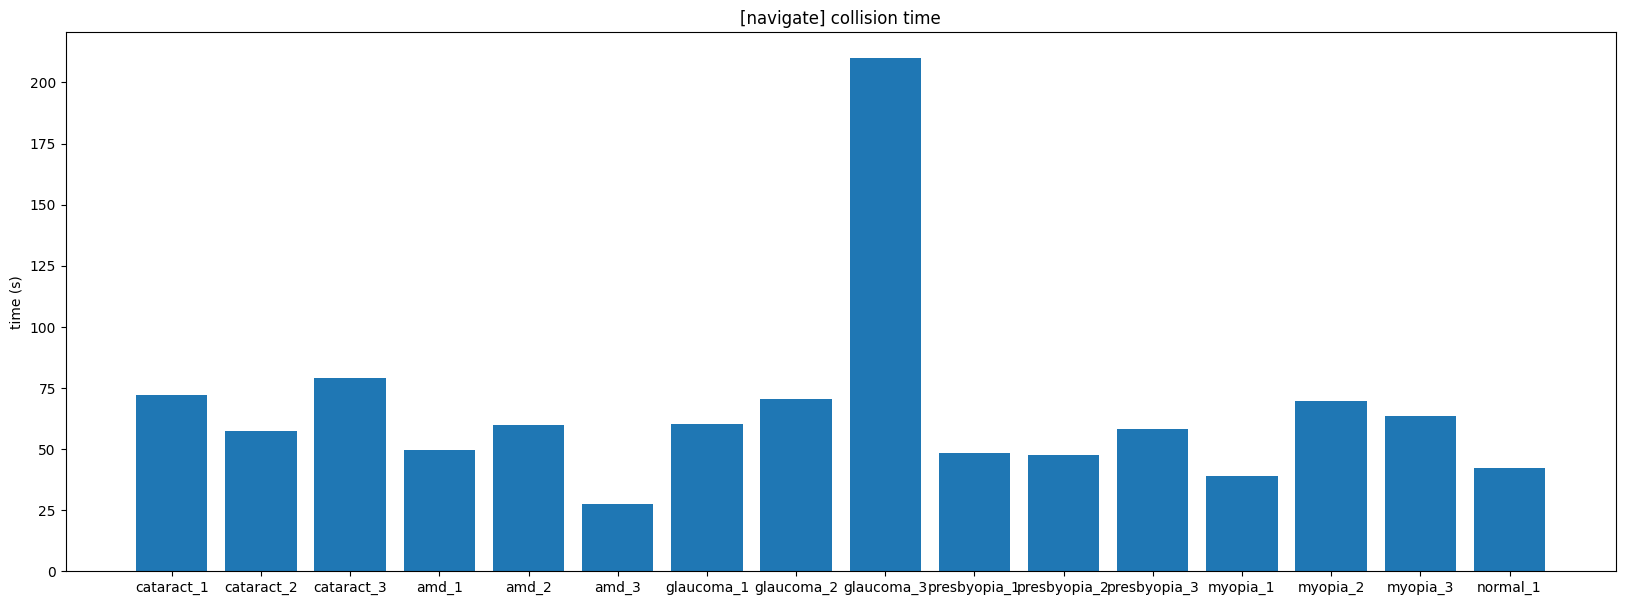

In [14]:
collisions = vi_data.get_data(key="/vr/vr_event_data/collisions", cond_id=[f"navigate_{vi}" for vi in vis], method=lambda x: np.sum(np.any(x, axis=1)))
avg_collisions = {}
for vi in vis:
    for i in range(5):
        avg_collisions[f"navigate_{vi}"] = np.mean(list(collisions[f"navigate_{vi}"].values()))
vi_data.bar_plot(data=list(avg_collisions.values()), tick_label=vis, title="[navigate] collision time", ylabel="time (s)")

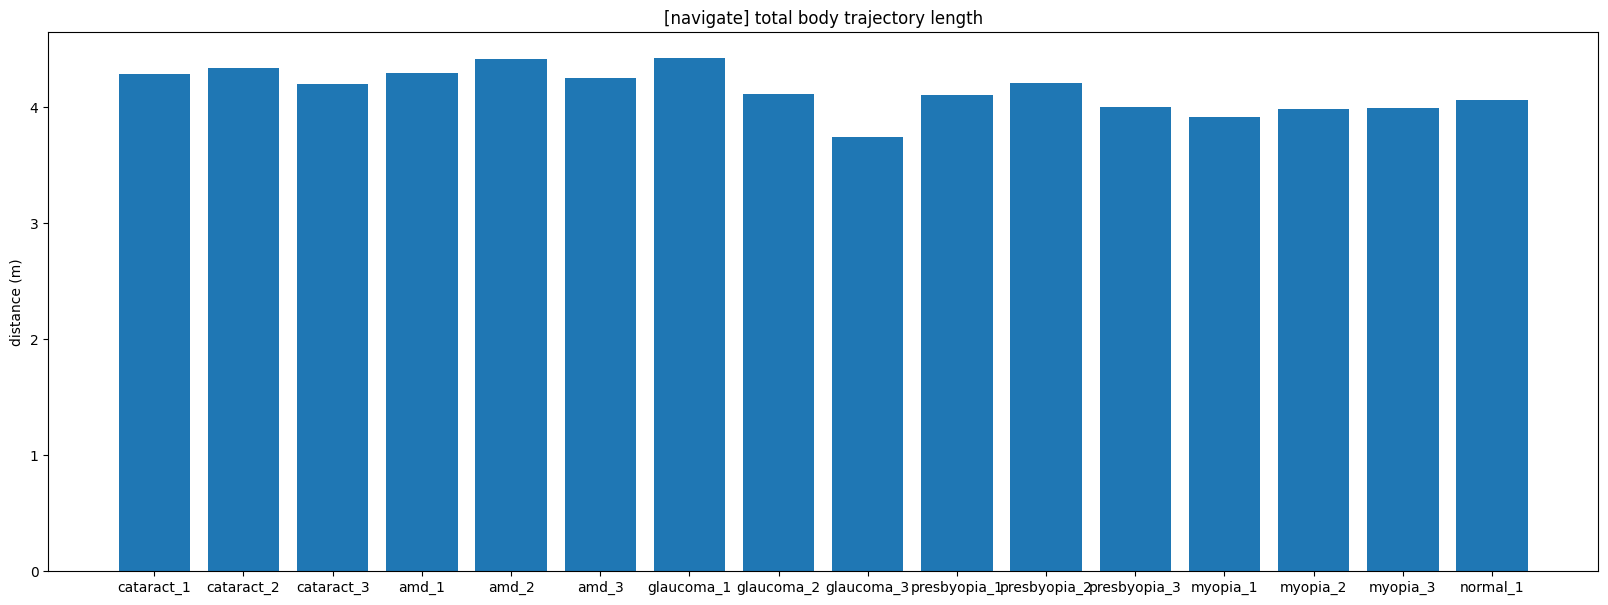

In [ ]:
torso_translation_data = vi_data.get_device_translation(cond_id=[f"navigate_{vi}" for vi in vis], method=np.sum)
avg_torso_translation_data = {task: {} for task in tasks}
for vi in vis:
    avg_torso_translation_data[task][vi] = np.mean(list(torso_translation_data[f"navigate_{vi}"].values()))
vi_data.bar_plot(data=list(avg_torso_translation_data[task].values()), tick_label=vis, title="[navigate] total body trajectory length", ylabel="distance (m)")

### movement of dominant hand for place and slice

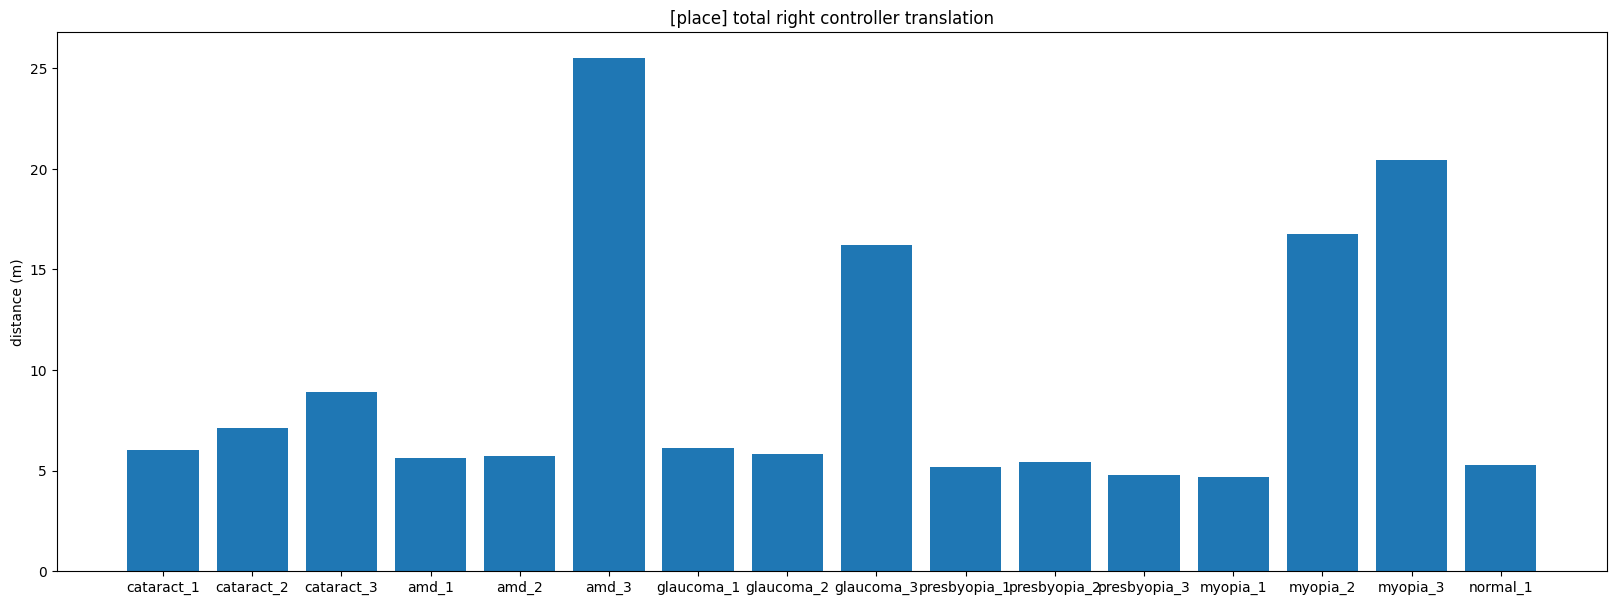

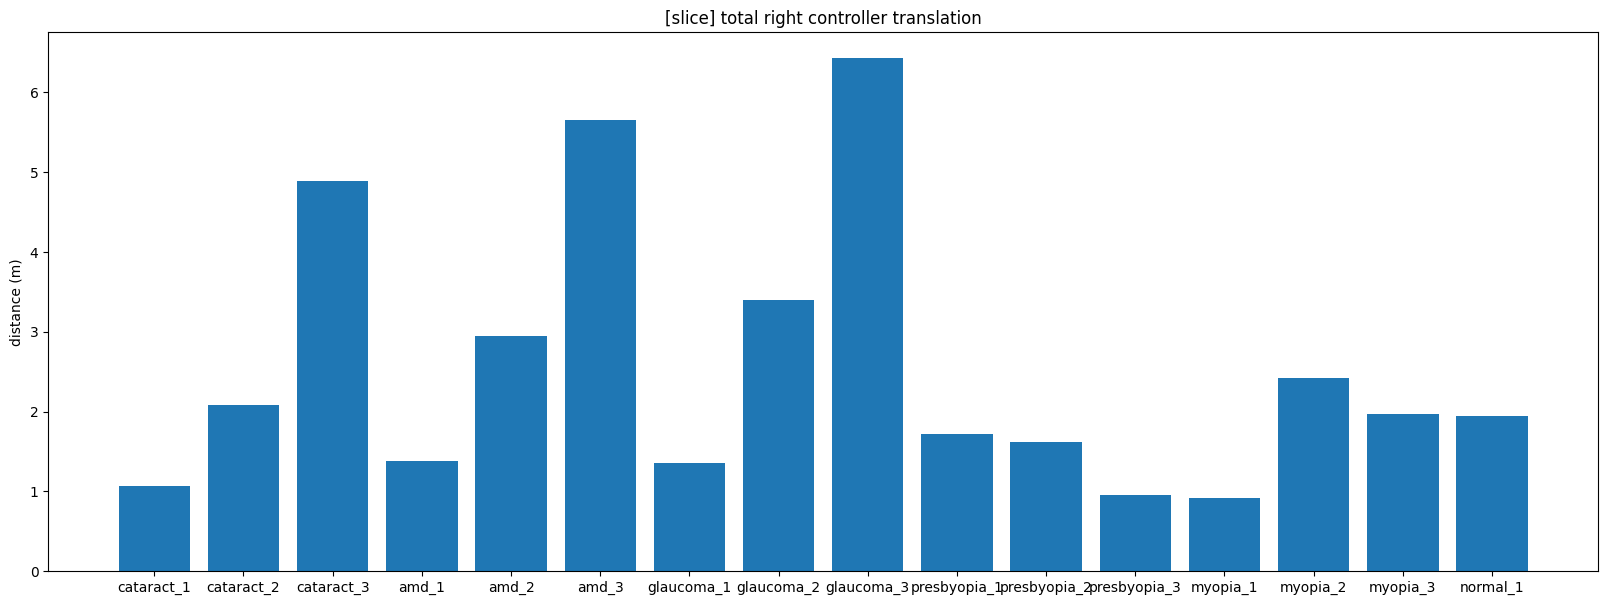

In [ ]:
dh_task = ["place", "slice"]
hand_data = vi_data.get_device_translation(device="right_controller", cond_id=[f"{task}_{vi}" for task, vi in product(dh_task, vis)], method=np.sum)
avg_hand_data = {task: {} for task in dh_task}
for task in dh_task:
    for vi in vis:
        avg_hand_data[task][vi] = np.mean(list(hand_data[f"{task}_{vi}"].values()))
    vi_data.bar_plot(data=list(avg_hand_data[task].values()), tick_label=vis, title=f"[{task}] total right controller translation", ylabel="distance (m)")

### irrelavant objects movement and brushing time for wipe

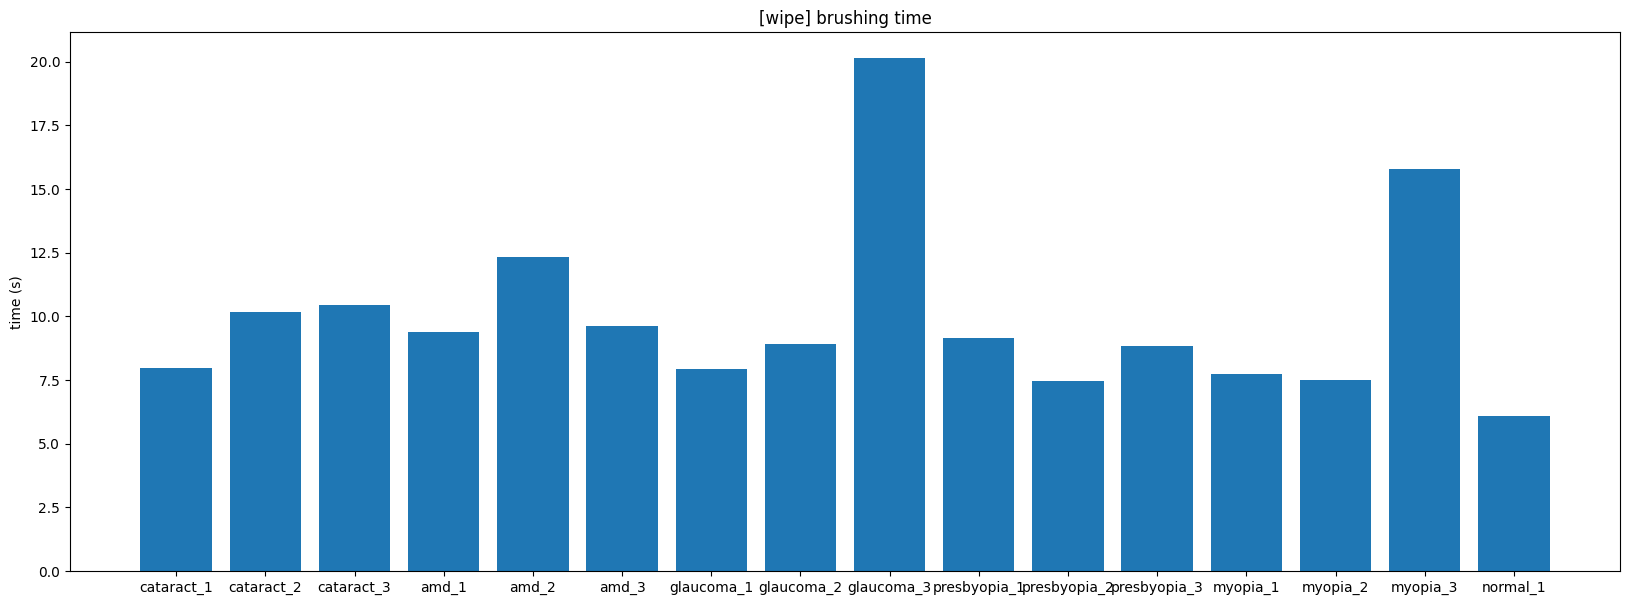

In [ ]:
brushing_time = vi_data.get_attr(key="/task_specific/total_brushing_time", cond_id=[f"wipe_{vi}" for vi in vis])
avg_brushing_time = {}
for vi in vis:
    avg_brushing_time[f"navigate_{vi}"] = np.mean(list(brushing_time[f"wipe_{vi}"].values()))
vi_data.bar_plot(data=list(avg_brushing_time.values()), tick_label=vis, title="[wipe] brushing time", ylabel="time (s)")

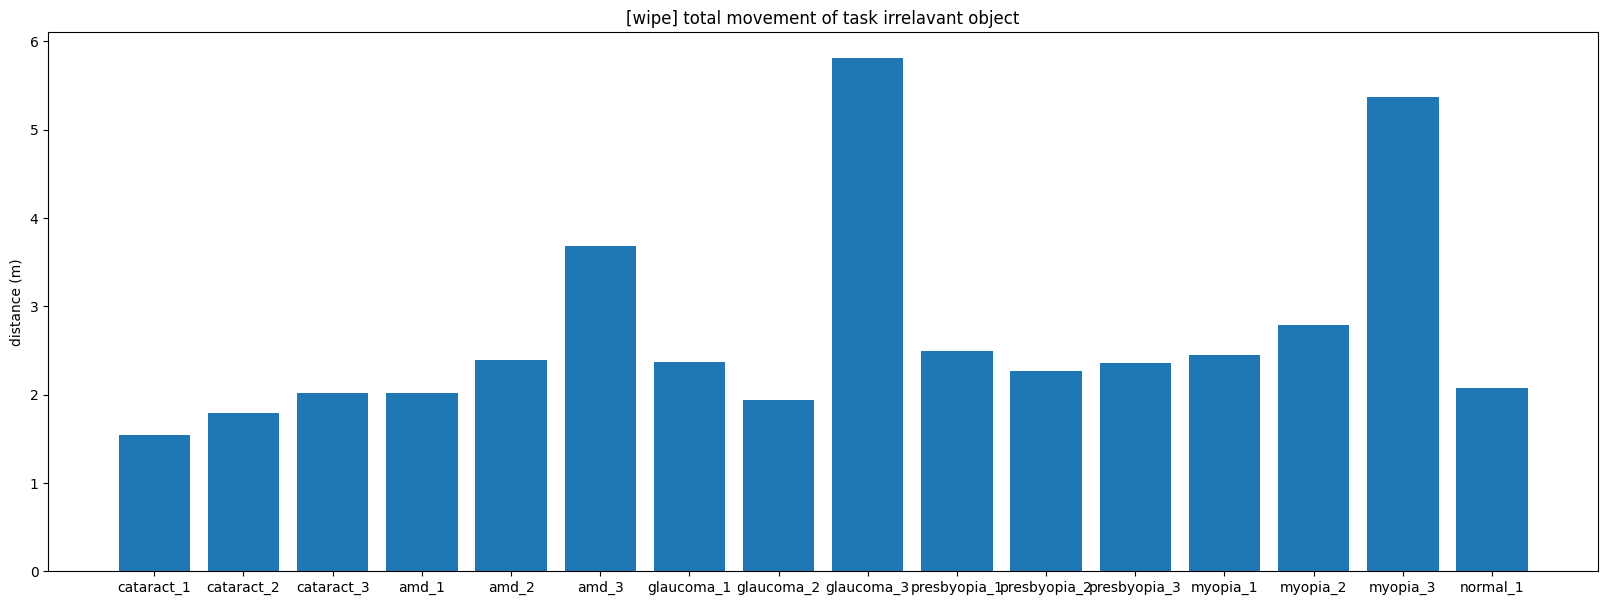

In [ ]:
irre_movement = vi_data.get_data(key="/total_movement_of_irrelavant_objs", cond_id=[f"wipe_{vi}" for vi in vis], method=lambda x:x[-1])
avg_irre_movement = {}
for vi in vis:
    avg_irre_movement[f"wipe_{vi}"] = np.mean(list(irre_movement[f"wipe_{vi}"].values()))
vi_data.bar_plot(data=list(avg_irre_movement.values()), tick_label=vis, title="[wipe] total movement of task irrelavant object", ylabel="distance (m)")

## Finally close hdf files

In [ ]:
del vi_data